# Interpretable Lead Scoring: Insights from SHAP and Explainable Boosting Machine

This project analyzes a dataset from an online education company that receives a high volume of leads daily through its website and marketing channels.  
The goal is to build a **lead scoring model** that assigns a probability score to each lead, and to gain **insights into the most relevant features driving conversion**, in order to support **marketing strategy recommendations**.

To achieve this, I applied a **multi-model approach**. I first trained an **XGBoost classifier** and interpreted it using **SHAP (SHapley Additive exPlanations)**. Then, I trained an **Explainable Boosting Machine (EBM)** and compared both models with the objective of analyzing differences in **predictive performance and interpretability**.

In this project, EBM is used not only to compare predictive performance but also to gain actionable insights about the relationship between lead features and conversion probability.  
Its interpretable structure allows us to validate whether model predictions align with real-world patterns and to derive marketing strategy recommendations based on those insights.

---

## Summary

- The EBM model provided consistent and interpretable predictions that closely aligned with real-world conversion patterns.
- While SHAP offers valuable insights for complex models, EBM proved more transparent and actionable in this case.
- Combining modeling with domain understanding enabled the extraction of **clear, evidence-based recommendations** for marketing strategy refinement.

---

## Recommended Actions for the Marketing Team

Based on the results obtained in this work, the following data-driven strategies are recommended:

1. **Prioritize SMS Outreach**: Since leads with a recent SMS interaction show higher conversion rates, integrating or intensifying SMS campaigns could be an effective conversion lever. Consider automated SMS follow-ups for warm leads.

2. **Segment Leads by Website Engagement Time**: Leads spending between **500 and 1800 seconds** on the website represent a high-conversion segment. Flagging and prioritizing these leads in the CRM can improve targeting efficiency.

3. **Design Content to Encourage Sustained Engagement**: Given that mid-range time-on-site correlates with conversion, marketing and UX teams can collaborate to structure landing pages and content to **retain users longer within the optimal time window**.

4. **Use Interpretable Models for Operational Insights**: EBM not only performs competitively but also provides actionable insights. Integrating interpretable models into marketing analytics pipelines can improve both decision-making and stakeholder communication.

In [282]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
import xgboost as xgb

# For missing values analysis:
import missingno as msno


%matplotlib inline

In [283]:
df = pd.read_csv("/Users/ramon/Proyectos Data Science/Proyecto Lead Scoring/lead_scoring.csv")
pd.set_option('display.max_columns', 40)
df.head()

Prospect ID  Lead Number              Lead Origin  \
0  7927b2df-8bba-4d29-b9a2-b6e0beafe620       660737                      API   
1  2a272436-5132-4136-86fa-dcc88c88f482       660728                      API   
2  8cc8c611-a219-4f35-ad23-fdfd2656bd8a       660727  Landing Page Submission   
3  0cc2df48-7cf4-4e39-9de9-19797f9b38cc       660719  Landing Page Submission   
4  3256f628-e534-4826-9d63-4a8b88782852       660681  Landing Page Submission   

      Lead Source Do Not Email Do Not Call  Converted  TotalVisits  \
0      Olark Chat           No          No          0          0.0   
1  Organic Search           No          No          0          5.0   
2  Direct Traffic           No          No          1          2.0   
3  Direct Traffic           No          No          0          1.0   
4          Google           No          No          1          2.0   

   Total Time Spent on Website  Page Views Per Visit            Last Activity  \
0                            0                   0.0  Page Visited on Website   
1                          674                   2.5             Email Opened   
2                         1532                   2.0             Email Opened   
3                          305                   1.0              Unreachable   
4                         1428                   1.0        Converted to Lead   

  Country           Specialization How did you hear about X Education  \
0     NaN                   Select                             Select   
1   India                   Select                             Select   
2   India  Business Administration                             Select   
3   India    Media and Advertising                      Word Of Mouth   
4   India                   Select                              Other   

  What is your current occupation  \
0                      Unemployed   
1                      Unemployed   
2                         Student   
3                      Unemployed   
4                      Unemployed   

  What matters most to you in choosing a course Search Magazine  \
0                       Better Career Prospects     No       No   
1                       Better Career Prospects     No       No   
2                       Better Career Prospects     No       No   
3                       Better Career Prospects     No       No   
4                       Better Career Prospects     No       No   

  Newspaper Article X Education Forums Newspaper Digital Advertisement  \
0                No                 No        No                    No   
1                No                 No        No                    No   
2                No                 No        No                    No   
3                No                 No        No                    No   
4                No                 No        No                    No   

  Through Recommendations Receive More Updates About Our Courses  \
0                      No                                     No   
1                      No                                     No   
2                      No                                     No   
3                      No                                     No   
4                      No                                     No   

                                  Tags      Lead Quality  \
0          Interested in other courses  Low in Relevance   
1                              Ringing               NaN   
2  Will revert after reading the email          Might be   
3                              Ringing          Not Sure   
4  Will revert after reading the email          Might be   

  Update me on Supply Chain Content Get updates on DM Content    Lead Profile  \
0                                No                        No          Select   
1                                No                        No          Select   
2                                No                        No  Potential Lead   
3                            

## Feature Description:


- **Prospect ID**: Unique identifier for the lead (UUID format).
- **Lead Number**: Internal numeric identifier for the lead.
- **Lead Origin**: The original source where the lead was generated (e.g., Landing Page, API).
- **Lead Source**: The marketing channel or platform that referred the lead (e.g., Olark Chat, Organic Search).
- **Do Not Email**: Whether the lead has opted out of receiving emails (Yes/No).
- **Do Not Call**: Whether the lead has opted out of receiving phone calls (Yes/No).
- **Converted**: Target variable indicating if the lead became a paying customer (1 = Yes, 0 = No).
- **TotalVisits**: Number of times the lead has visited the website.
- **Total Time Spent on Website**: Total duration (in seconds) the lead spent on the website.
- **Page Views Per Visit**: Average number of pages viewed per website visit.
- **Last Activity**: The most recent action the lead performed (e.g., Email Opened, Page Visited).
- **Country**: The country of the lead (often missing or labeled "Select").
- **Specialization**: The area of interest or educational background the lead selected.
- **How did you hear about X Education**: Lead’s response to how they found out about the platform.
- **What is your current occupation**: Employment status or profession of the lead.
- **What matters most to you in choosing a course**: Self-declared priority for selecting a course (e.g., Better Career Prospects).
- **Search**: Whether the lead used the search function on the website (Yes/No).
- **Magazine**: Whether the lead came through a magazine promotion (Yes/No).
- **Newspaper Article**: Whether the lead came through a newspaper article (Yes/No).
- **X Education Forums**: Whether the lead came from education forums (Yes/No).
- **Newspaper**: Whether the lead was referred through a newspaper (Yes/No).
- **Digital Advertisement**: Whether the lead came from digital ads (Yes/No).
- **Through Recommendations**: Whether the lead came from word-of-mouth or referrals (Yes/No).
- **Receive More Updates About Our Courses**: Whether the lead subscribed to receive further updates (Yes/No).
- **Tags**: Internal tags or labels associated with the lead (e.g., "Interested in other courses").
- **Lead Quality**: Internal quality rating of the lead (e.g., High in Relevance, Low in Relevance).
- **Update me on Supply Chain Content**: Whether the lead wants updates on supply chain content (Yes/No).
- **Get updates on DM Content**: Whether the lead wants updates on digital marketing content (Yes/No).
- **Lead Profile**: Lead's category or profile label (e.g., Student, Working Professional).
- **City**: City of the lead (often missing or labeled "Select").
- **Asymmetrique Activity Index**: Internal activity category assigned to the lead (ordinal level, e.g., "02.Medium").
- **Asymmetrique Profile Index**: Internal profile classification of the lead (ordinal, e.g., "02.Medium").
- **Asymmetrique Activity Score**: Numeric score measuring lead's activity.
- **Asymmetrique Profile Score**: Numeric score measuring lead's profile strength.
- **I agree to pay the amount through cheque**: Whether the lead agreed to pay via cheque (Yes/No).
- **A free copy of Mastering The Interview**: Whether the lead requested a free guide (Yes/No).
- **Last Notable Activity**: The most important or recent qualifying interaction by the lead.


## 1) Initial dataset exploration:

In [284]:
df.shape

(9240, 37)

In [285]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9240 entries, 0 to 9239
Data columns (total 37 columns):
 #   Column                                         Non-Null Count  Dtype  
---  ------                                         --------------  -----  
 0   Prospect ID                                    9240 non-null   object 
 1   Lead Number                                    9240 non-null   int64  
 2   Lead Origin                                    9240 non-null   object 
 3   Lead Source                                    9204 non-null   object 
 4   Do Not Email                                   9240 non-null   object 
 5   Do Not Call                                    9240 non-null   object 
 6   Converted                                      9240 non-null   int64  
 7   TotalVisits                                    9103 non-null   float64
 8   Total Time Spent on Website                    9240 non-null   int64  
 9   Page Views Per Visit                           9103 

In [286]:
df = df.drop(columns=["Prospect ID"])
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9240 entries, 0 to 9239
Data columns (total 36 columns):
 #   Column                                         Non-Null Count  Dtype  
---  ------                                         --------------  -----  
 0   Lead Number                                    9240 non-null   int64  
 1   Lead Origin                                    9240 non-null   object 
 2   Lead Source                                    9204 non-null   object 
 3   Do Not Email                                   9240 non-null   object 
 4   Do Not Call                                    9240 non-null   object 
 5   Converted                                      9240 non-null   int64  
 6   TotalVisits                                    9103 non-null   float64
 7   Total Time Spent on Website                    9240 non-null   int64  
 8   Page Views Per Visit                           9103 non-null   float64
 9   Last Activity                                  9137 

- We can observe there is no date so nothing to correct regarding dtype.
- Most features are objects. I will first try using XGBoost with enable_categorical=True, that enables Categorical Features without doing previous encoding. Easier. 
- There are some missing values as Non-Null < df.shape[0]

In [287]:
# I will convert object features to categorical:

df[df.select_dtypes(["object"]).columns] = df.select_dtypes(["object"]).astype("category")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9240 entries, 0 to 9239
Data columns (total 36 columns):
 #   Column                                         Non-Null Count  Dtype   
---  ------                                         --------------  -----   
 0   Lead Number                                    9240 non-null   int64   
 1   Lead Origin                                    9240 non-null   category
 2   Lead Source                                    9204 non-null   category
 3   Do Not Email                                   9240 non-null   category
 4   Do Not Call                                    9240 non-null   category
 5   Converted                                      9240 non-null   int64   
 6   TotalVisits                                    9103 non-null   float64 
 7   Total Time Spent on Website                    9240 non-null   int64   
 8   Page Views Per Visit                           9103 non-null   float64 
 9   Last Activity                            

In [288]:
df.duplicated().sum() # Check duplicates

0

In [289]:
df.describe()

Lead Number    Converted  TotalVisits  Total Time Spent on Website  \
count    9240.000000  9240.000000  9103.000000                  9240.000000   
mean   617188.435606     0.385390     3.445238                   487.698268   
std     23405.995698     0.486714     4.854853                   548.021466   
min    579533.000000     0.000000     0.000000                     0.000000   
25%    596484.500000     0.000000     1.000000                    12.000000   
50%    615479.000000     0.000000     3.000000                   248.000000   
75%    637387.250000     1.000000     5.000000                   936.000000   
max    660737.000000     1.000000   251.000000                  2272.000000   

       Page Views Per Visit  Asymmetrique Activity Score  \
count           9103.000000                  5022.000000   
mean               2.362820                    14.306252   
std                2.161418                     1.386694   
min                0.000000                     7.000000   
25%                1.000000                    14.000000   
50%                2.000000                    14.000000   
75%                3.000000                    15.000000   
max               55.000000                    18.000000   

       Asymmetrique Profile Score  
count                 5022.000000  
mean                    16.344883  
std                      1.811395  
min                     11.000000  
25%                     15.000000  
50%                     16.000000  
75%                     18.000000  
max                     20.000000

## 2) Missing Values:

In [290]:
missing_count = df.isnull().sum()

missing_percentage = (100 * missing_count / df.shape[0]).sort_values(ascending=False)

In [291]:
missing_percentage

Lead Quality                                     51.590909
Asymmetrique Activity Index                      45.649351
Asymmetrique Profile Index                       45.649351
Asymmetrique Profile Score                       45.649351
Asymmetrique Activity Score                      45.649351
Tags                                             36.287879
Lead Profile                                     29.318182
What matters most to you in choosing a course    29.318182
What is your current occupation                  29.112554
Country                                          26.634199
How did you hear about X Education               23.885281
Specialization                                   15.562771
City                                             15.367965
Page Views Per Visit                              1.482684
TotalVisits                                       1.482684
Last Activity                                     1.114719
Lead Source                                       0.3896

In [292]:
# I will put all this information in a dataframe:

missing_df = pd.DataFrame({
    "missing_count": missing_count,
    "missing_percentage": missing_percentage
}).sort_values(ascending=False, by="missing_count")

# I will keep only those columns which have >1 NaN:

missing_df = missing_df[missing_df["missing_count"] > 0]

missing_df

missing_count  \
Lead Quality                                            4767   
Asymmetrique Activity Score                             4218   
Asymmetrique Profile Index                              4218   
Asymmetrique Profile Score                              4218   
Asymmetrique Activity Index                             4218   
Tags                                                    3353   
Lead Profile                                            2709   
What matters most to you in choosing a course           2709   
What is your current occupation                         2690   
Country                                                 2461   
How did you hear about X Education                      2207   
Specialization                                          1438   
City                                                    1420   
Page Views Per Visit                                     137   
TotalVisits                                              137   
Last Activity                                            103   
Lead Source                                               36   

                                               missing_percentage  
Lead Quality                                            51.590909  
Asymmetrique Activity Score                             45.649351  
Asymmetrique Profile Index                              45.649351  
Asymmetrique Profile Score                              45.649351  
Asymmetrique Activity Index                             45.649351  
Tags                                                    36.287879  
Lead Profile                                            29.318182  
What matters most to you in choosing a course           29.318182  
What is your current occupation                         29.112554  
Country                                                 26.634199  
How did you hear about X Education                      23.885281  
Specialization                                          15.562771  
City                                                    15.367965  
Page Views Per Visit                                     1.482684  
TotalVisits                                              1.482684  
Last Activity                                            1.114719  
Lead Source                                              0.389610

In [293]:
# I will drop those columns where missing_count > 50%

def drop_missing_columns(drop_threshold):
    columns_to_drop = missing_df[missing_df["missing_percentage"] >= drop_threshold].index.tolist()

    df.drop(columns = columns_to_drop, inplace = True) # Drop those columns that > drop_threshold

    print(f"{columns_to_drop} have been deleted")

In [294]:
drop_missing_columns(50)

['Lead Quality'] have been deleted


In [295]:
%matplotlib inline

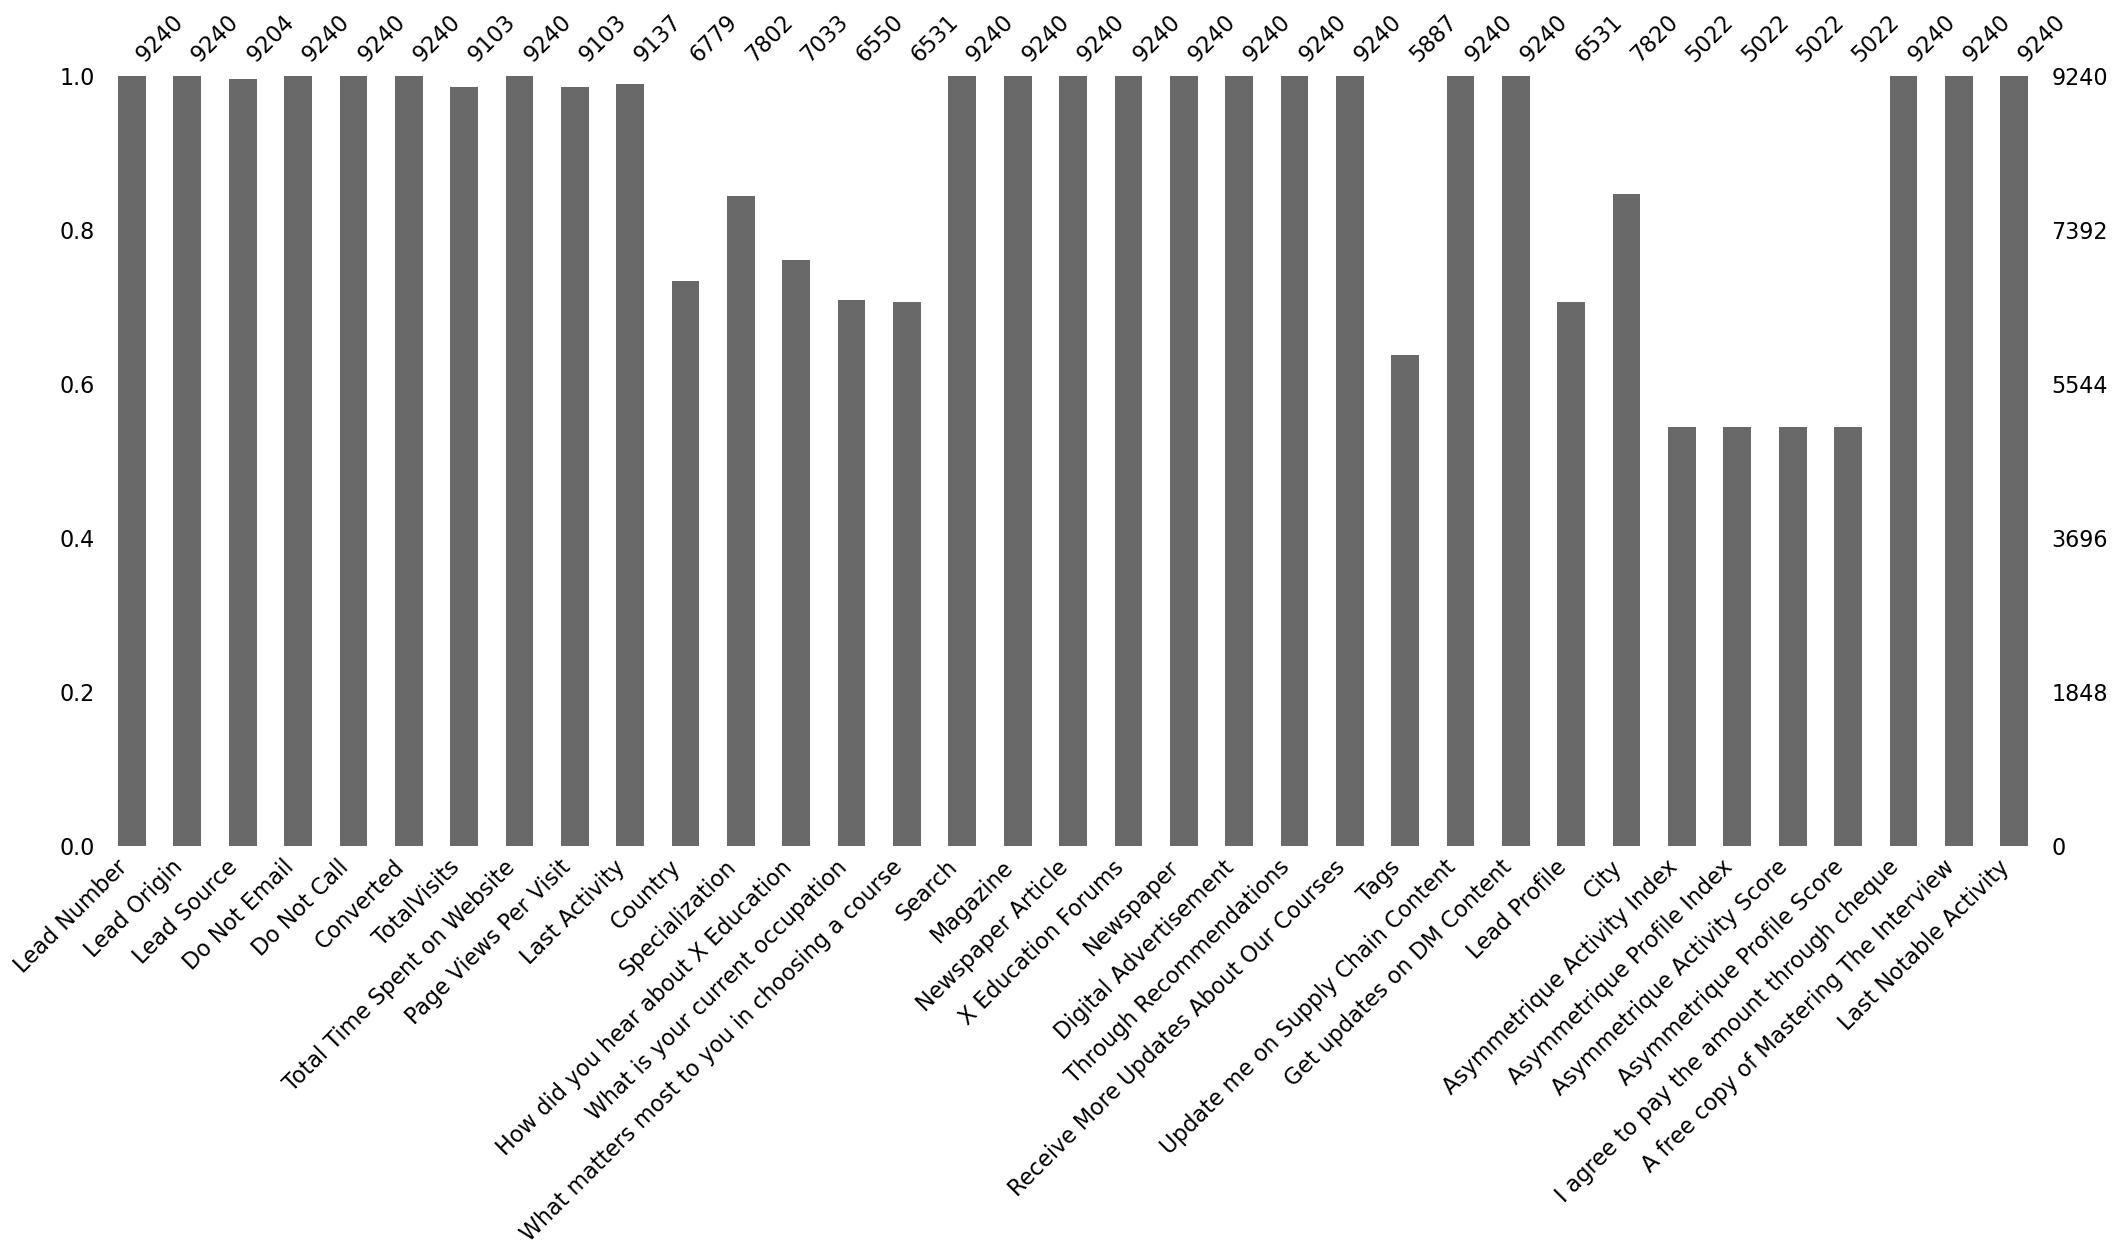

In [296]:
msno.bar(df)
plt.show()

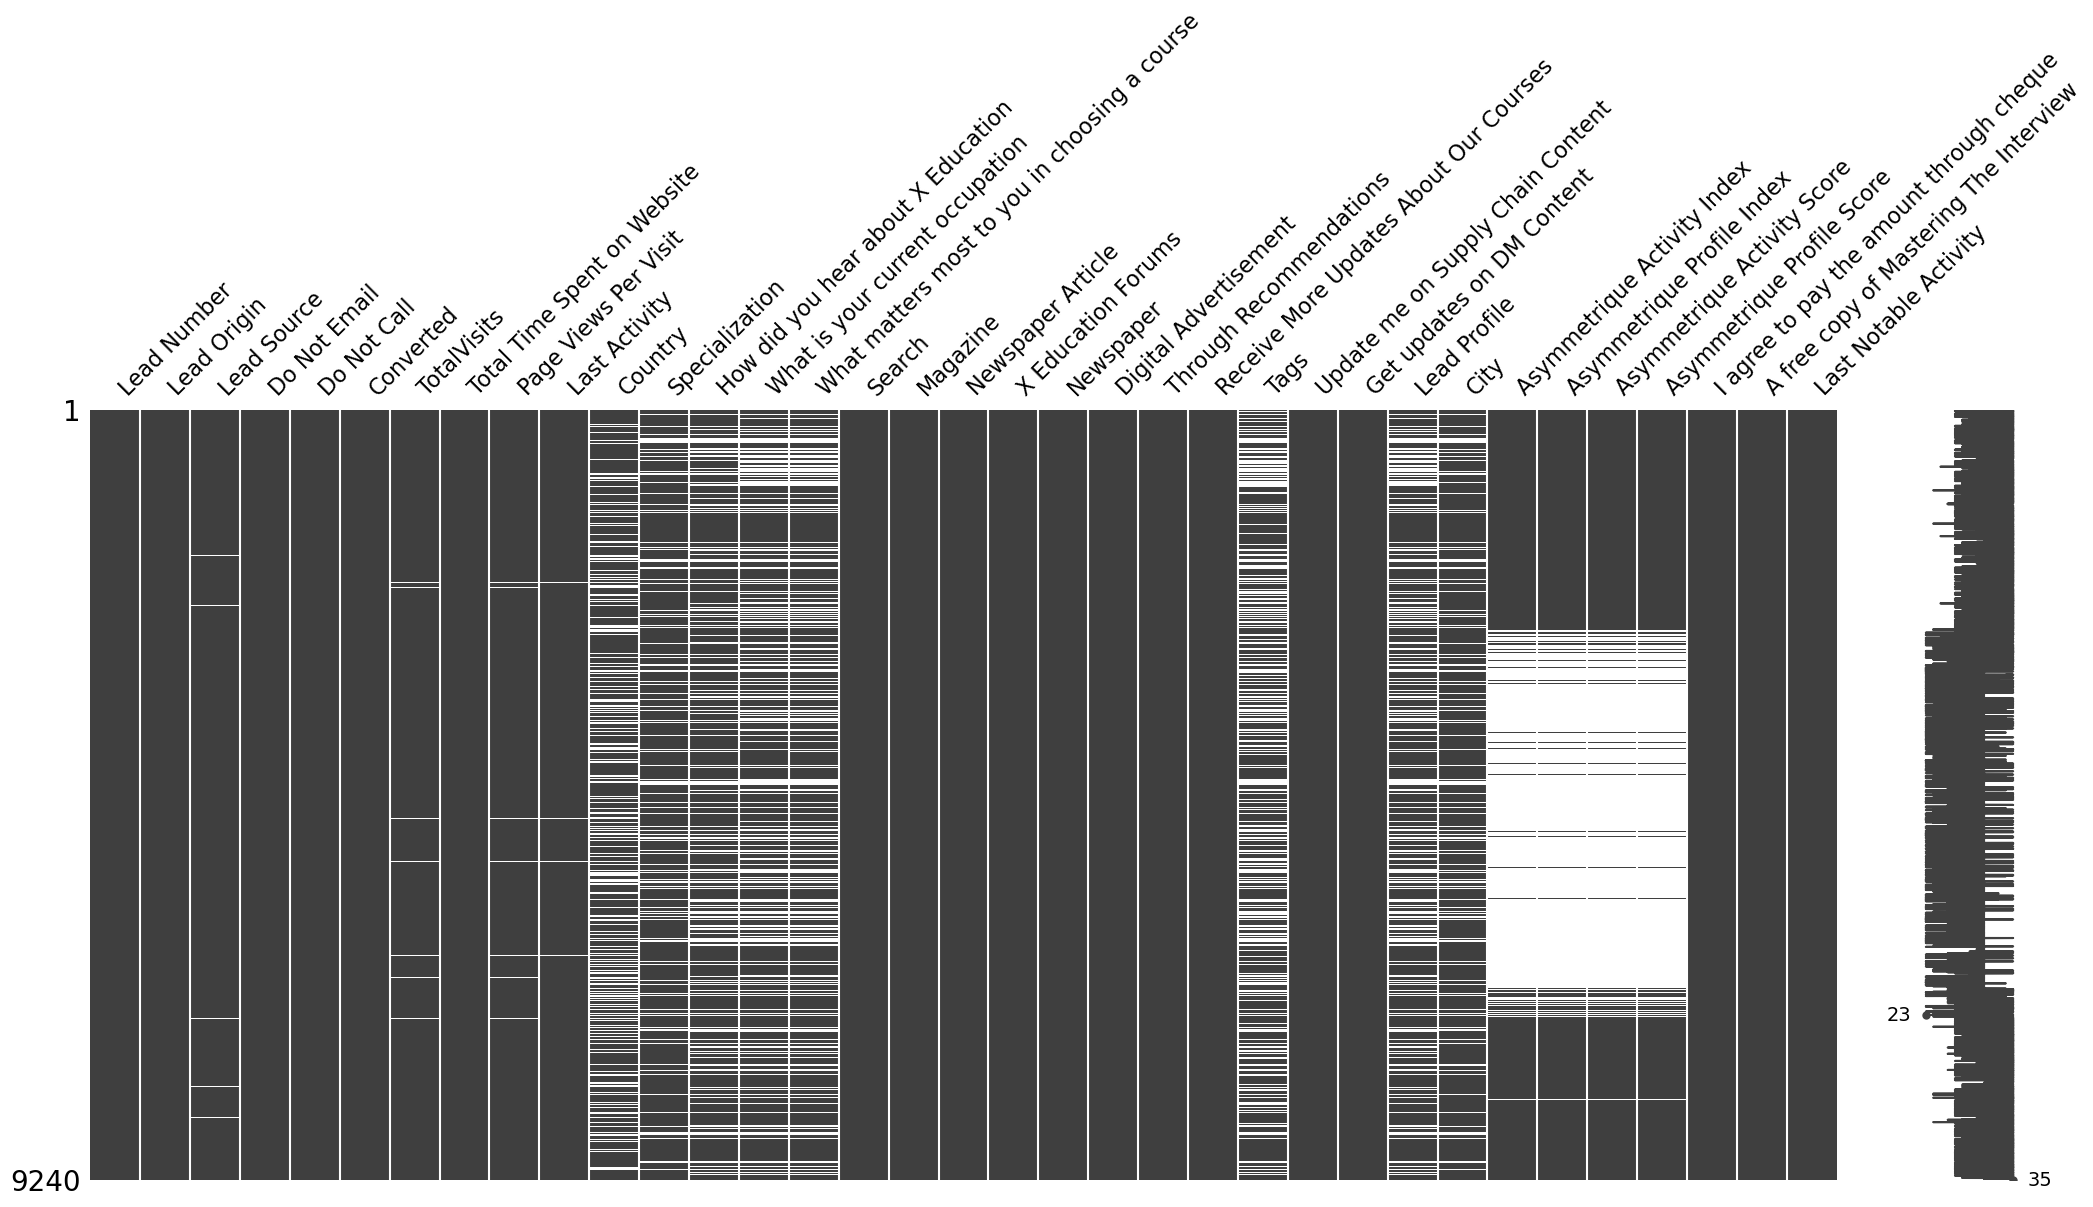

In [297]:
msno.matrix(df)
plt.show()

# To see where the missing values are located. 

- Those columns that have a random dispersion of NaN could suggest that are MCAR (missing completely at random). But as % of missing values is high, I will include a Flag.
- We can see that there are four columns with a distinctive pattern of NaN. 

In [298]:
num_cols = df.select_dtypes(include = 'number').columns
cat_cols = df.select_dtypes(include = 'category').columns

### 2.1) Numeric features imputation:

In [299]:
num_cols # Is a list of numeric features names.

Index(['Lead Number', 'Converted', 'TotalVisits',
       'Total Time Spent on Website', 'Page Views Per Visit',
       'Asymmetrique Activity Score', 'Asymmetrique Profile Score'],
      dtype='object')

In [300]:
missing_count_num = df[num_cols].isnull().sum()

missing_percentage_num = (100 * missing_count_num / df.shape[0]).sort_values(ascending=False)

In [301]:
missing_percentage_num

Asymmetrique Activity Score    45.649351
Asymmetrique Profile Score     45.649351
TotalVisits                     1.482684
Page Views Per Visit            1.482684
Lead Number                     0.000000
Converted                       0.000000
Total Time Spent on Website     0.000000
dtype: float64

In [302]:
# For TotalVisits and Page Views Per Visit I will imput missing values with median:

from sklearn.impute import SimpleImputer

imputer = SimpleImputer(strategy = 'median')
df[["TotalVisits","Page Views Per Visit"]] = imputer.fit_transform(df[["TotalVisits","Page Views Per Visit"]])

In [303]:
missing_count_num = df[num_cols].isnull().sum()

missing_percentage_num = (100 * missing_count_num / df.shape[0]).sort_values(ascending=False)
missing_percentage_num

Asymmetrique Activity Score    45.649351
Asymmetrique Profile Score     45.649351
Lead Number                     0.000000
Converted                       0.000000
TotalVisits                     0.000000
Total Time Spent on Website     0.000000
Page Views Per Visit            0.000000
dtype: float64

In [304]:
# For Asymmetrique Activity Score and Asymmetrique Profile Score, as the have a non random distribution inside the dataset I will:
# 1) Imput missing values with the median.

to_flag = ['Asymmetrique Activity Score', 'Asymmetrique Profile Score']

for col in to_flag:
    df[col] = df[col].fillna(df[col].median())

In [305]:
missing_count_num = df[num_cols].isnull().sum()

missing_percentage_num = (100 * missing_count_num / df.shape[0]).sort_values(ascending=False)
missing_percentage_num

Lead Number                    0.0
Converted                      0.0
TotalVisits                    0.0
Total Time Spent on Website    0.0
Page Views Per Visit           0.0
Asymmetrique Activity Score    0.0
Asymmetrique Profile Score     0.0
dtype: float64

### 2.2) Categoric features imputation:

In [306]:
cat_cols

Index(['Lead Origin', 'Lead Source', 'Do Not Email', 'Do Not Call',
       'Last Activity', 'Country', 'Specialization',
       'How did you hear about X Education', 'What is your current occupation',
       'What matters most to you in choosing a course', 'Search', 'Magazine',
       'Newspaper Article', 'X Education Forums', 'Newspaper',
       'Digital Advertisement', 'Through Recommendations',
       'Receive More Updates About Our Courses', 'Tags',
       'Update me on Supply Chain Content', 'Get updates on DM Content',
       'Lead Profile', 'City', 'Asymmetrique Activity Index',
       'Asymmetrique Profile Index',
       'I agree to pay the amount through cheque',
       'A free copy of Mastering The Interview', 'Last Notable Activity'],
      dtype='object')

In [307]:
missing_count_cat = df[cat_cols].isnull().sum()

missing_percentage_cat = (100 * missing_count_cat / df.shape[0]).sort_values(ascending=False)
missing_percentage_cat

Asymmetrique Profile Index                       45.649351
Asymmetrique Activity Index                      45.649351
Tags                                             36.287879
Lead Profile                                     29.318182
What matters most to you in choosing a course    29.318182
What is your current occupation                  29.112554
Country                                          26.634199
How did you hear about X Education               23.885281
Specialization                                   15.562771
City                                             15.367965
Last Activity                                     1.114719
Lead Source                                       0.389610
Get updates on DM Content                         0.000000
Lead Origin                                       0.000000
I agree to pay the amount through cheque          0.000000
A free copy of Mastering The Interview            0.000000
Update me on Supply Chain Content                 0.0000

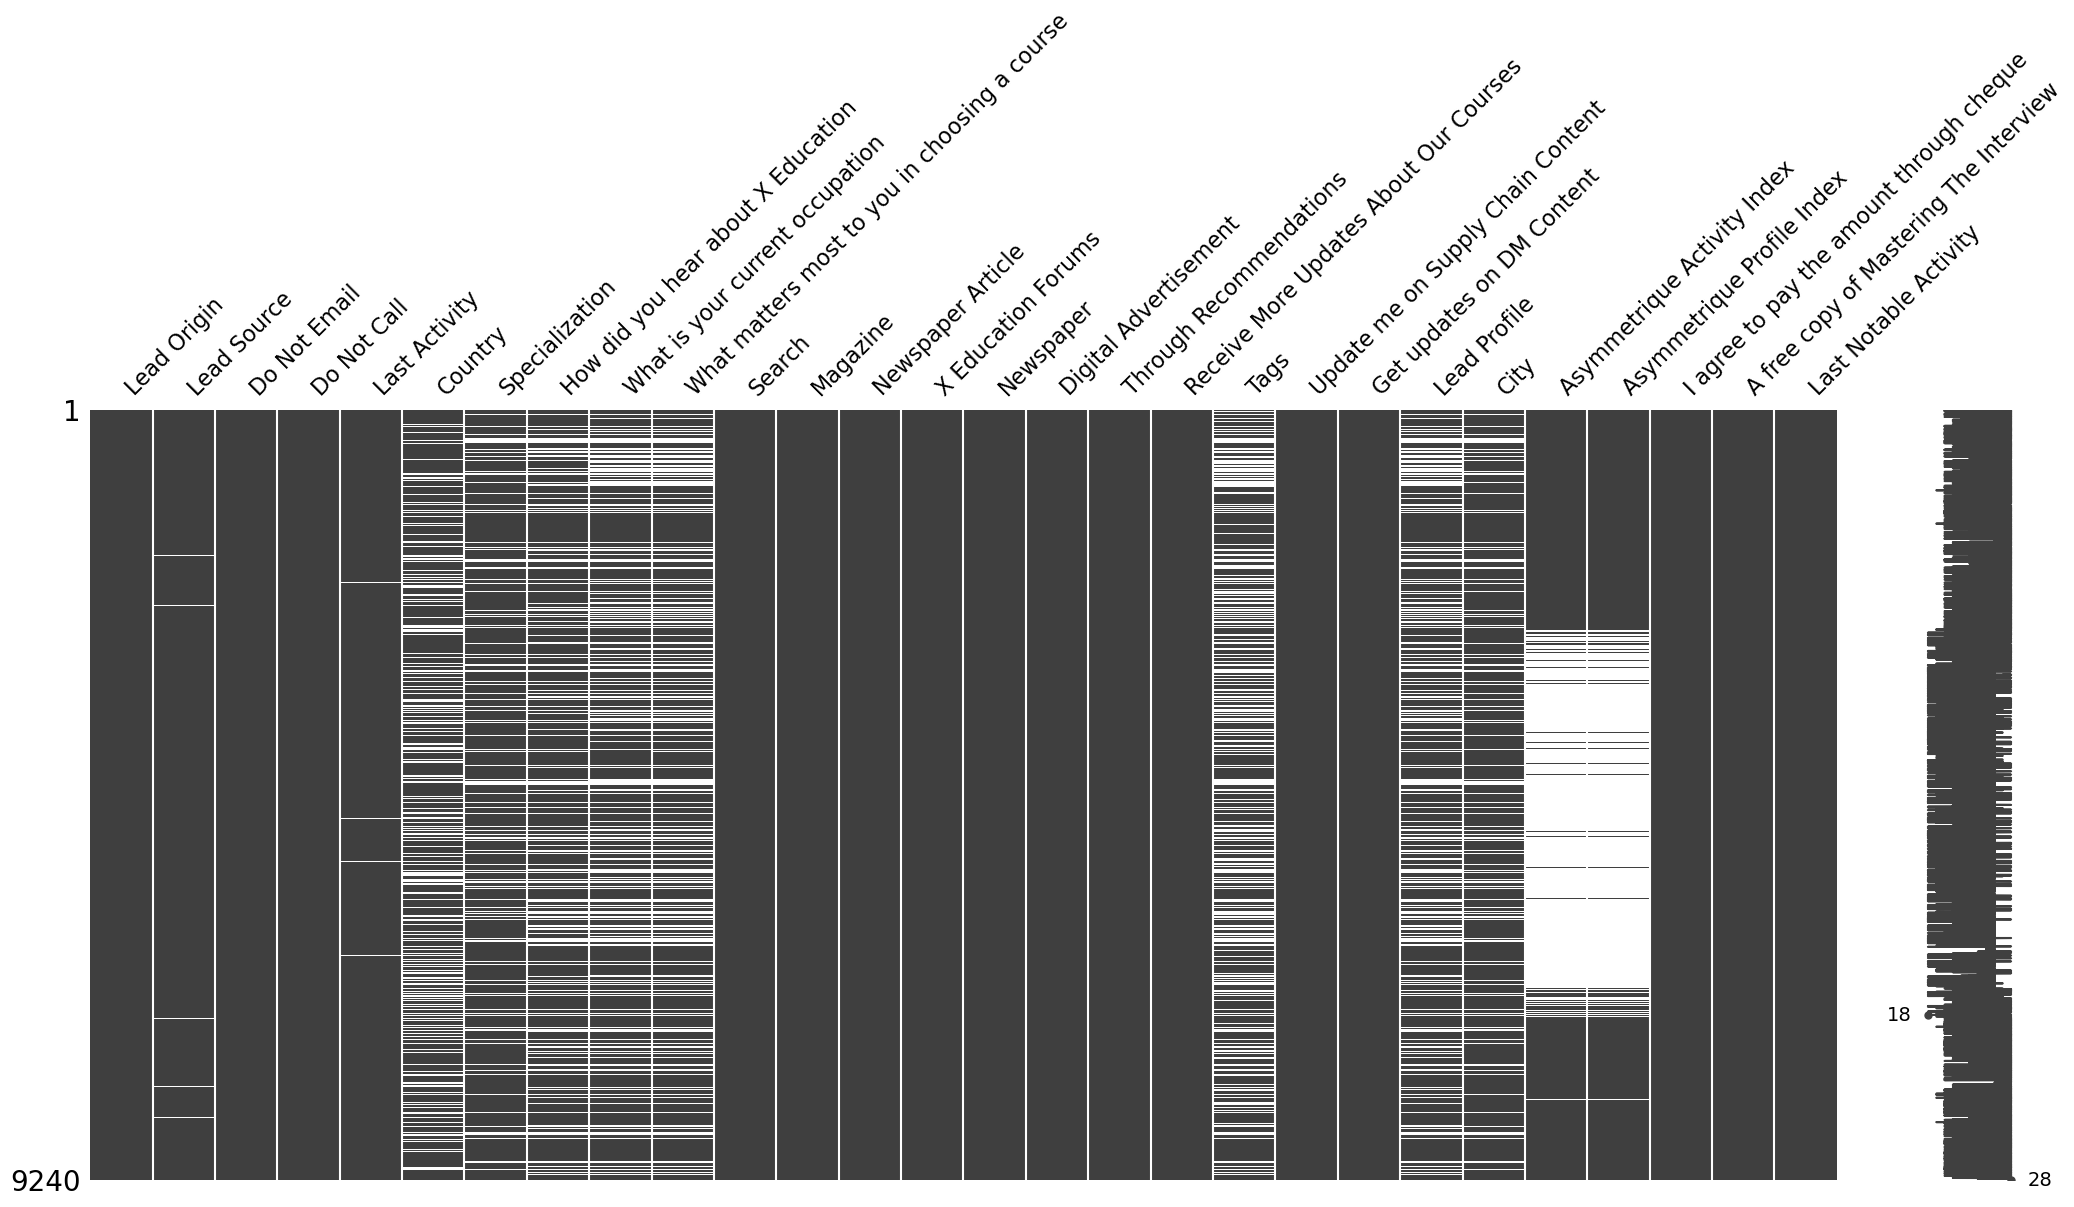

In [308]:
msno.matrix(df[cat_cols])
plt.show()

- We can see that most features with missing values have a random distribution of missing values. BUT, the % es 15-36% so I will include a Flag, because maybe it's valuable information. 
- For Asymmetrique Profile Index and Asymmetrique Activity Index, I will impute with "Unkown" + create flag (extra feature).

In [309]:
# For Lead Source and Last Activity, as < 5% of missing values I will directly impute with mostr_frequent:

impute_cat = [["Last Activity","Lead Source"]]

imp = SimpleImputer(strategy = "most_frequent")

for cat in impute_cat:
    df[cat] = imp.fit_transform(df[cat])

In [310]:
# For rest cat_variables with random dispersion -> Impute 

missing_percentage_cat = missing_percentage_cat.reset_index()
missing_percentage_cat

index          0
0                      Asymmetrique Profile Index  45.649351
1                     Asymmetrique Activity Index  45.649351
2                                            Tags  36.287879
3                                    Lead Profile  29.318182
4   What matters most to you in choosing a course  29.318182
5                 What is your current occupation  29.112554
6                                         Country  26.634199
7              How did you hear about X Education  23.885281
8                                  Specialization  15.562771
9                                            City  15.367965
10                                  Last Activity   1.114719
11                                    Lead Source   0.389610
12                      Get updates on DM Content   0.000000
13                                    Lead Origin   0.000000
14       I agree to pay the amount through cheque   0.000000
15         A free copy of Mastering The Interview   0.000000
16              Update me on Supply Chain Content   0.000000
17                                      Newspaper   0.000000
18         Receive More Updates About Our Courses   0.000000
19                        Through Recommendations   0.000000
20                          Digital Advertisement   0.000000
21                             X Education Forums   0.000000
22                              Newspaper Article   0.000000
23                                       Magazine   0.000000
24                                         Search   0.000000
25                                    Do Not Call   0.000000
26                                   Do Not Email   0.000000
27                          Last Notable Activity   0.000000

In [311]:
impute_cat_flag = missing_percentage_cat[missing_percentage_cat[0] >= 15]["index"].tolist()

In [312]:
for cat_flag in impute_cat_flag:
    df[cat_flag] = df[cat_flag].cat.add_categories("Unknown")
    df[cat_flag] = df[cat_flag].fillna("Unknown")

In [313]:
missing_count_cat = df[cat_cols].isnull().sum()

missing_percentage_cat = (100 * missing_count_cat / df.shape[0]).sort_values(ascending=False)
missing_percentage_cat

Lead Origin                                      0.0
Lead Source                                      0.0
A free copy of Mastering The Interview           0.0
I agree to pay the amount through cheque         0.0
Asymmetrique Profile Index                       0.0
Asymmetrique Activity Index                      0.0
City                                             0.0
Lead Profile                                     0.0
Get updates on DM Content                        0.0
Update me on Supply Chain Content                0.0
Tags                                             0.0
Receive More Updates About Our Courses           0.0
Through Recommendations                          0.0
Digital Advertisement                            0.0
Newspaper                                        0.0
X Education Forums                               0.0
Newspaper Article                                0.0
Magazine                                         0.0
Search                                        

In [314]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9240 entries, 0 to 9239
Data columns (total 35 columns):
 #   Column                                         Non-Null Count  Dtype   
---  ------                                         --------------  -----   
 0   Lead Number                                    9240 non-null   int64   
 1   Lead Origin                                    9240 non-null   category
 2   Lead Source                                    9240 non-null   object  
 3   Do Not Email                                   9240 non-null   category
 4   Do Not Call                                    9240 non-null   category
 5   Converted                                      9240 non-null   int64   
 6   TotalVisits                                    9240 non-null   float64 
 7   Total Time Spent on Website                    9240 non-null   int64   
 8   Page Views Per Visit                           9240 non-null   float64 
 9   Last Activity                            

Missing values handled.

## 3) Exploratory Analysis:

### 3.1) Outliers:

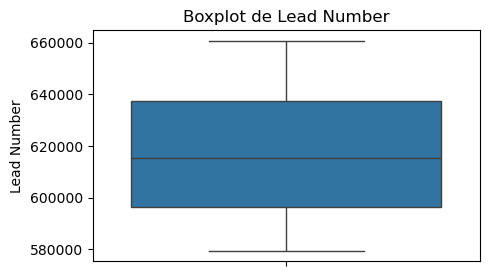

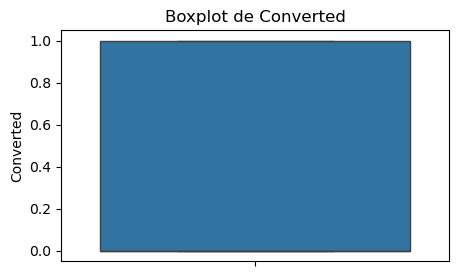

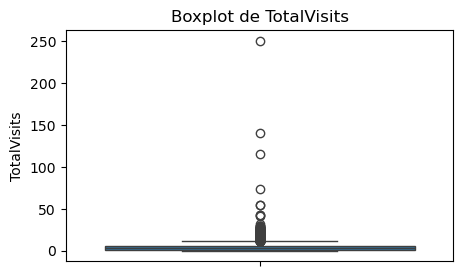

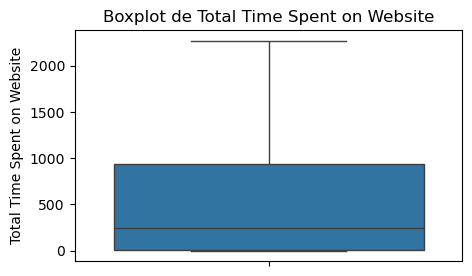

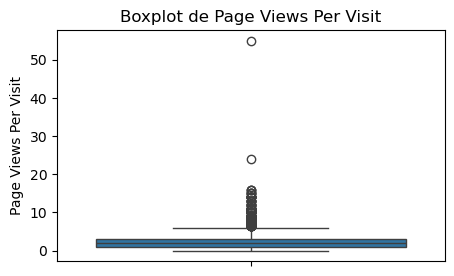

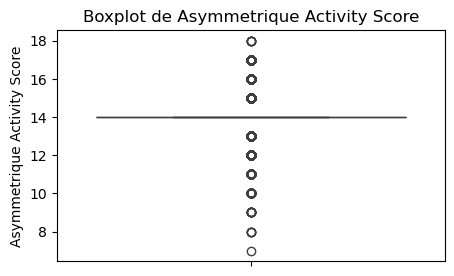

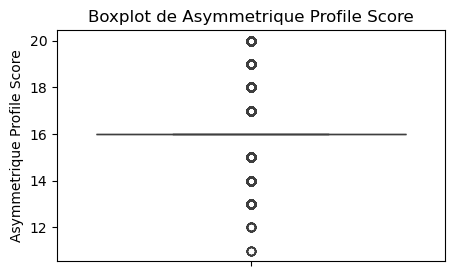

In [315]:
for col in num_cols:
    plt.figure(figsize = (5,3))
    sns.boxplot(df[col])
    plt.title(f"Boxplot de {col}")
    plt.show()

In [316]:
def describe_outliers():
    x= df.shape[0]
    df_outliers = pd.DataFrame(index = range(x))
    df_outliers
    
    
    all_columns = df.select_dtypes(include = "number").columns
    
    for col in all_columns:
      Q1 = df[col].quantile(0.25)
      Q2 = df[col].quantile(0.75)
      IQR = Q2 - Q1
      lower_bound = Q1 - 1.5* IQR
      upper_bound = Q2 + 1.5* IQR
    
    
      outliers_column = df[col].where((df[col] < lower_bound) | (df[col] > upper_bound))
    
      df_outliers[col] = outliers_column
    
    
    return df_outliers.describe()

describe_outliers()

Lead Number  Converted  TotalVisits  Total Time Spent on Website  \
count          0.0        0.0   267.000000                          0.0   
mean           NaN        NaN    18.655431                          NaN   
std            NaN        NaN    18.592413                          NaN   
min            NaN        NaN    12.000000                          NaN   
25%            NaN        NaN    13.000000                          NaN   
50%            NaN        NaN    15.000000                          NaN   
75%            NaN        NaN    19.000000                          NaN   
max            NaN        NaN   251.000000                          NaN   

       Page Views Per Visit  Asymmetrique Activity Score  \
count            360.000000                  3251.000000   
mean               8.626611                    14.473085   
std                3.259985                     1.700533   
min                6.330000                     7.000000   
25%                7.000000                    13.000000   
50%                8.000000                    15.000000   
75%                9.000000                    16.000000   
max               55.000000                    18.000000   

       Asymmetrique Profile Score  
count                 4423.000000  
mean                    16.391589  
std                      1.925440  
min                     11.000000  
25%                     15.000000  
50%                     15.000000  
75%                     18.000000  
max                     20.000000

Routine inspection. XGBoost is robust to outliers so I will go on with analysis. If I see model performance is compromised maybe this could be something to explore.

## 3.2) Numeric Variable Distributions:

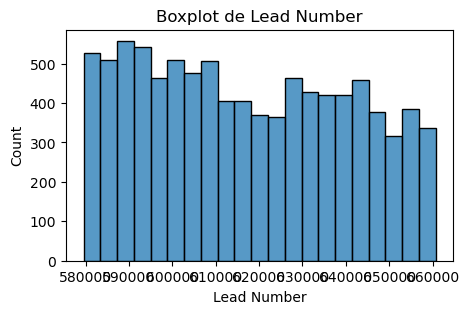

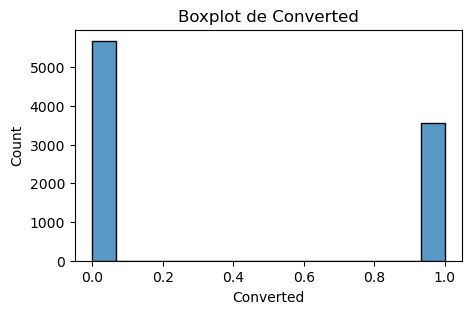

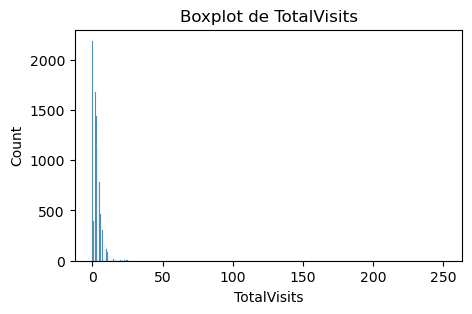

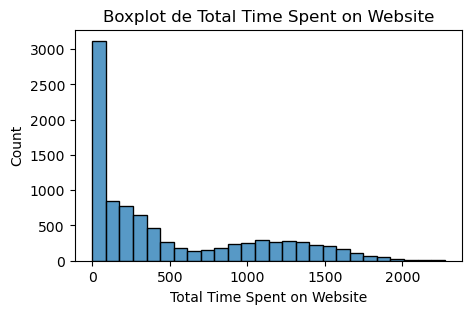

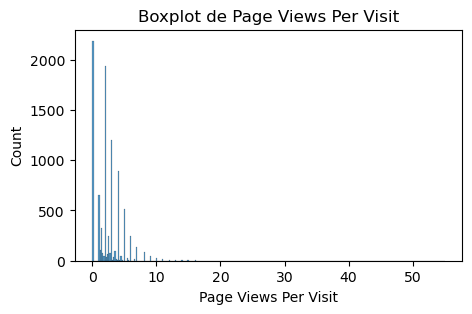

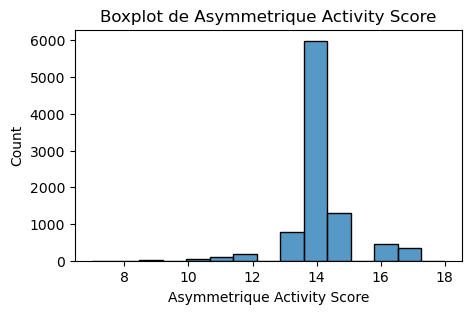

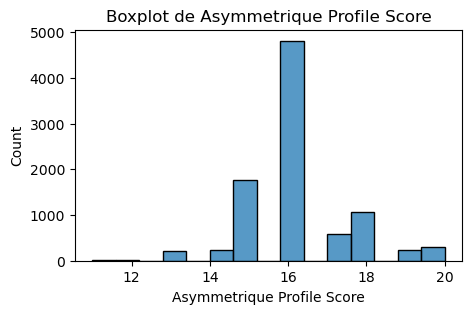

In [37]:
for col in num_cols:
    plt.figure(figsize = (5,3))
    sns.histplot(df[col])
    plt.title(f"Boxplot de {col}")
    plt.show()



## 4) Model: 

In [317]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9240 entries, 0 to 9239
Data columns (total 35 columns):
 #   Column                                         Non-Null Count  Dtype   
---  ------                                         --------------  -----   
 0   Lead Number                                    9240 non-null   int64   
 1   Lead Origin                                    9240 non-null   category
 2   Lead Source                                    9240 non-null   object  
 3   Do Not Email                                   9240 non-null   category
 4   Do Not Call                                    9240 non-null   category
 5   Converted                                      9240 non-null   int64   
 6   TotalVisits                                    9240 non-null   float64 
 7   Total Time Spent on Website                    9240 non-null   int64   
 8   Page Views Per Visit                           9240 non-null   float64 
 9   Last Activity                            

In [318]:
df[df.select_dtypes(["object"]).columns] = df.select_dtypes(["object"]).astype("category")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9240 entries, 0 to 9239
Data columns (total 35 columns):
 #   Column                                         Non-Null Count  Dtype   
---  ------                                         --------------  -----   
 0   Lead Number                                    9240 non-null   int64   
 1   Lead Origin                                    9240 non-null   category
 2   Lead Source                                    9240 non-null   category
 3   Do Not Email                                   9240 non-null   category
 4   Do Not Call                                    9240 non-null   category
 5   Converted                                      9240 non-null   int64   
 6   TotalVisits                                    9240 non-null   float64 
 7   Total Time Spent on Website                    9240 non-null   int64   
 8   Page Views Per Visit                           9240 non-null   float64 
 9   Last Activity                            

In [319]:
# I will check if the leads are balanced (the target)

df.groupby("Converted")["Lead Number"].count()

Converted
0    5679
1    3561
Name: Lead Number, dtype: int64

We can see that leads are not balanced, so I will include the argument stratify en train_test_split so that leads are balanced between train/test.

In [320]:
cat_features = df.select_dtypes(include=["category"]).columns.tolist()

df_dum = pd.get_dummies(data=df,
                                prefix=cat_features,
                                drop_first=True,
                                columns=cat_features).astype(float)
df_dum 

Lead Number  Converted  TotalVisits  Total Time Spent on Website  \
0        660737.0        0.0          0.0                          0.0   
1        660728.0        0.0          5.0                        674.0   
2        660727.0        1.0          2.0                       1532.0   
3        660719.0        0.0          1.0                        305.0   
4        660681.0        1.0          2.0                       1428.0   
...           ...        ...          ...                          ...   
9235     579564.0        1.0          8.0                       1845.0   
9236     579546.0        0.0          2.0                        238.0   
9237     579545.0        0.0          2.0                        199.0   
9238     579538.0        1.0          3.0                        499.0   
9239     579533.0        1.0          6.0                       1279.0   

      Page Views Per Visit  Asymmetrique Activity Score  \
0                     0.00                         15.0   
1                     2.50                         15.0   
2                     2.00                         14.0   
3                     1.00                         13.0   
4                     1.00                         15.0   
...                    ...                          ...   
9235                  2.67                         15.0   
9236                  2.00                         14.0   
9237                  2.00                         13.0   
9238                  3.00                         15.0   
9239                  3.00                         15.0   

      Asymmetrique Profile Score  Lead Origin_Landing Page Submission  \
0                           15.0                                  0.0   
1                           15.0                                  0.0   
2                           20.0                                  1.0   
3                           17.0                                  1.0   
4                           18.0                                  1.0   
...                          ...                                  ...   
9235                        17.0                                  1.0   
9236                        19.0                                  1.0   
9237                        20.0                                  1.0   
9238                        16.0                                  1.0   
9239                        18.0                                  1.0   

      Lead Origin_Lead Add Form  Lead Origin_Lead Import  \
0                           0.0                      0.0   
1                           0.0                      0.0   
2                           0.0                      0.0   
3                           0.0                      0.0   
4                           0.0                      0.0   
...                         ...                      ...   
9235                        0.0                      0.0   
9236                        0.0                      0.0   
9237                        0.0                      0.0   
9238                        0.0                      0.0   
9239                        0.0                      0.0   

      Lead Origin_Quick Add Form  Lead Source_Direct Traffic  \
0                            0.0                         0.0   
1                            0.0                         0.0   
2                            0.0                         1.0   
3                            0.0                         1.0   
4                            0.0                         0.0   
...                          ...                         ...   
9235                         0.0                         1.0   
9236                         0.0                         1.0   
9237                         0.0                         1.0   
9238                         0.0                         0.0   
9239                         0.0                         1.0   

      Lead Source_Facebook  Lead Source_G

In [321]:
# Split the data:

y_data = df_dum["Converted"]
X_data = df_dum.drop(columns =["Converted","Lead Number"])


X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, test_size=0.1, stratify=y_data,  random_state=123)

In [322]:
X_train.shape[0]+X_test.shape[0]

9240

In [323]:
n = int(len(X_train)*0.8)
n

# I will use the 80% of the train data to train the model, the 20% to evaluate the model in each round.

6652

In [324]:
# So I will selectt the first n examples for the X_train_fit and the from n onwards as the X_train_eval

X_train_fit, X_train_eval, y_train_fit, y_train_eval = X_train[:n], X_train[n:], y_train[:n], y_train[n:]

In [325]:
from xgboost import XGBClassifier

In [326]:
# Now I define the model:
xgb_model = XGBClassifier(n_estimators=500, 
                          learning_rate = 0.1, 
                          early_stopping_rounds=10, 
                          eval_metric="logloss",
                          random_state = 123)
# Train the model:
xgb_model.fit(X_train_fit, 
              y_train_fit, 
              eval_set=[(X_train_eval, y_train_eval)], 
              verbose=True)

[0]	validation_0-logloss:0.59890
[1]	validation_0-logloss:0.54433
[2]	validation_0-logloss:0.49978
[3]	validation_0-logloss:0.46289
[4]	validation_0-logloss:0.43155
[5]	validation_0-logloss:0.40517
[6]	validation_0-logloss:0.37970
[7]	validation_0-logloss:0.35702
[8]	validation_0-logloss:0.33457
[9]	validation_0-logloss:0.31824
[10]	validation_0-logloss:0.30204
[11]	validation_0-logloss:0.28798
[12]	validation_0-logloss:0.27397
[13]	validation_0-logloss:0.26401
[14]	validation_0-logloss:0.25204
[15]	validation_0-logloss:0.24439
[16]	validation_0-logloss:0.23478
[17]	validation_0-logloss:0.22843
[18]	validation_0-logloss:0.22094
[19]	validation_0-logloss:0.21484
[20]	validation_0-logloss:0.20993
[21]	validation_0-logloss:0.20522
[22]	validation_0-logloss:0.20036
[23]	validation_0-logloss:0.19671
[24]	validation_0-logloss:0.19300
[25]	validation_0-logloss:0.18986
[26]	validation_0-logloss:0.18720
[27]	validation_0-logloss:0.18500
[28]	validation_0-logloss:0.18248
[29]	validation_0-loglos

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=10,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.1, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=500,
              n_jobs=None, num_parallel_tree=None, random_state=123, ...)

In [327]:
xgb_model.best_iteration

78

The best round of training was round 78, with a log loss of 0.16301

(As early_stopping_roundswas set to 10, after the 10th round where the log loss doesn't improve, training stops.)

## 5) Model Evaluation:

I want to evaluate the model for having a high sensivility (find the most of the converted leads), but also having a low proportion of False + (i.e. I want to have high Precision). So I will evaluate the F1-Score which is a Harmonic Mean between both metrics. 

To analyze Bias and Variance I will evaluate only F1-Score.

In [328]:
from sklearn.metrics import f1_score 
from sklearn.metrics import precision_score, recall_score

In [329]:
print(f"F1-Score for Train Set is {f1_score(xgb_model.predict(X_train), y_train):.4f}")
print(f"F1-Score for Test Set is {f1_score(xgb_model.predict(X_test), y_test):.4f}")

print(f"Precision for Train Set is {precision_score(xgb_model.predict(X_train), y_train):.4f}")
print(f"Precision for Test Set is {precision_score(xgb_model.predict(X_test), y_test):.4f}")

print(f"Recall for Train Set is {recall_score(xgb_model.predict(X_train), y_train):.4f}")
print(f"Recall for Test Set is {recall_score(xgb_model.predict(X_test), y_test):.4f}")

F1-Score for Train Set is 0.9462
F1-Score for Test Set is 0.9284
Precision for Train Set is 0.9351
Precision for Test Set is 0.9101
Recall for Train Set is 0.9575
Recall for Test Set is 0.9474


- The performance of the model is very high, as the F1-score for the test set reaches 0.9462, indicating a strong balance between precision and recall.
- Additionally, the small gap between the F1-scores of the training (0.9462) and test (0.9284) sets suggests that there is no evidence of overfitting — the model generalizes well.
- When analyzing precision and recall separately, we observe that both metrics are consistently high across training and test sets. This implies that the model is able to identify a large proportion of converting leads (recall = 0.9474 on test), while maintaining a high proportion of true positives among its positive predictions (precision = 0.9101 on test).

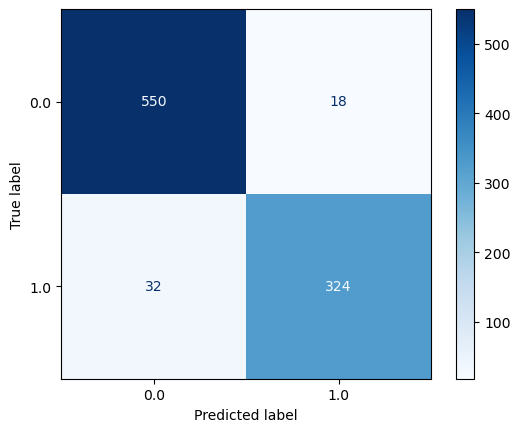

In [330]:
from sklearn.metrics import ConfusionMatrixDisplay 

predictions = xgb_model.predict(X_test)
disp = ConfusionMatrixDisplay.from_predictions(
    y_pred=predictions, 
    y_true=y_test,
    cmap='Blues'
)

plt.show()

In [331]:
import shap

explainer = shap.Explainer(xgb_model, X_train)
shap_values = explainer(X_test)

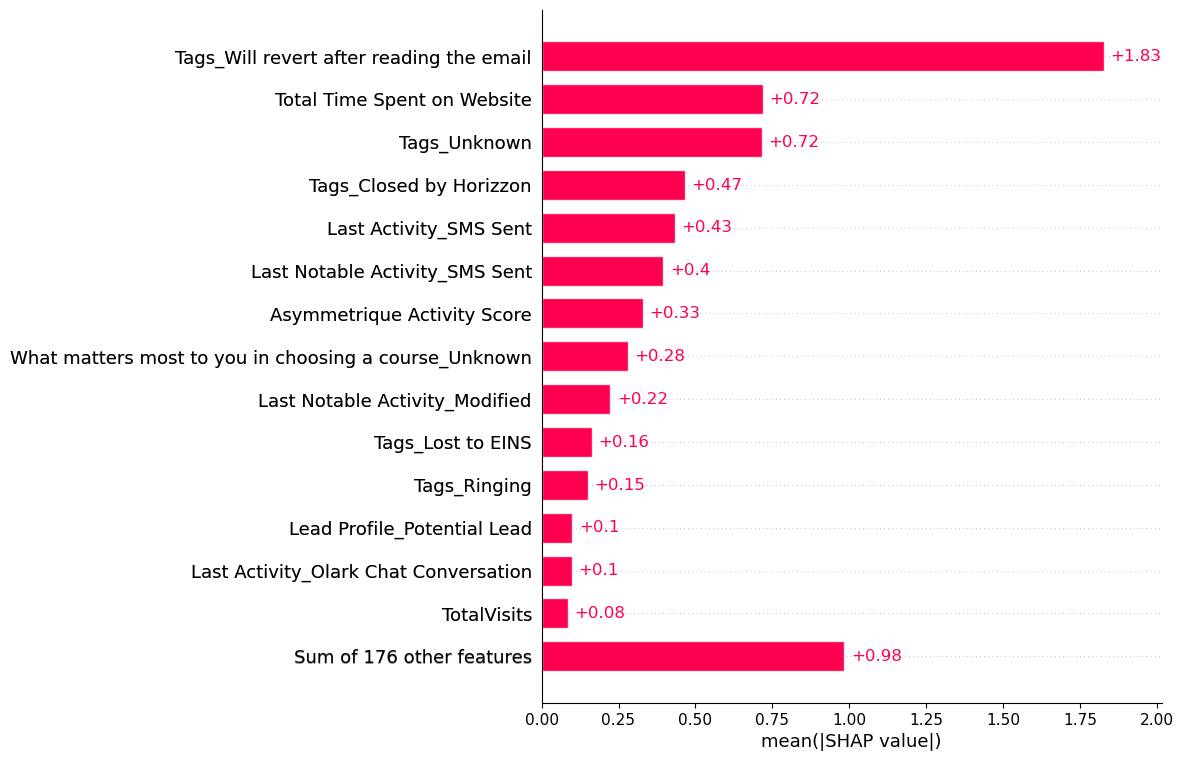

In [343]:
shap.plots.bar(shap_values, max_display=15)

This plot shows the average of the absolute SHAP values for each feature. It is a measure of the feature importance on the prediction. As the absolute values are used, this plot doesn't show if the feature affects pushing up or down the prediction. The plot below will use this to organize the features in order of importance.

The plot show that 

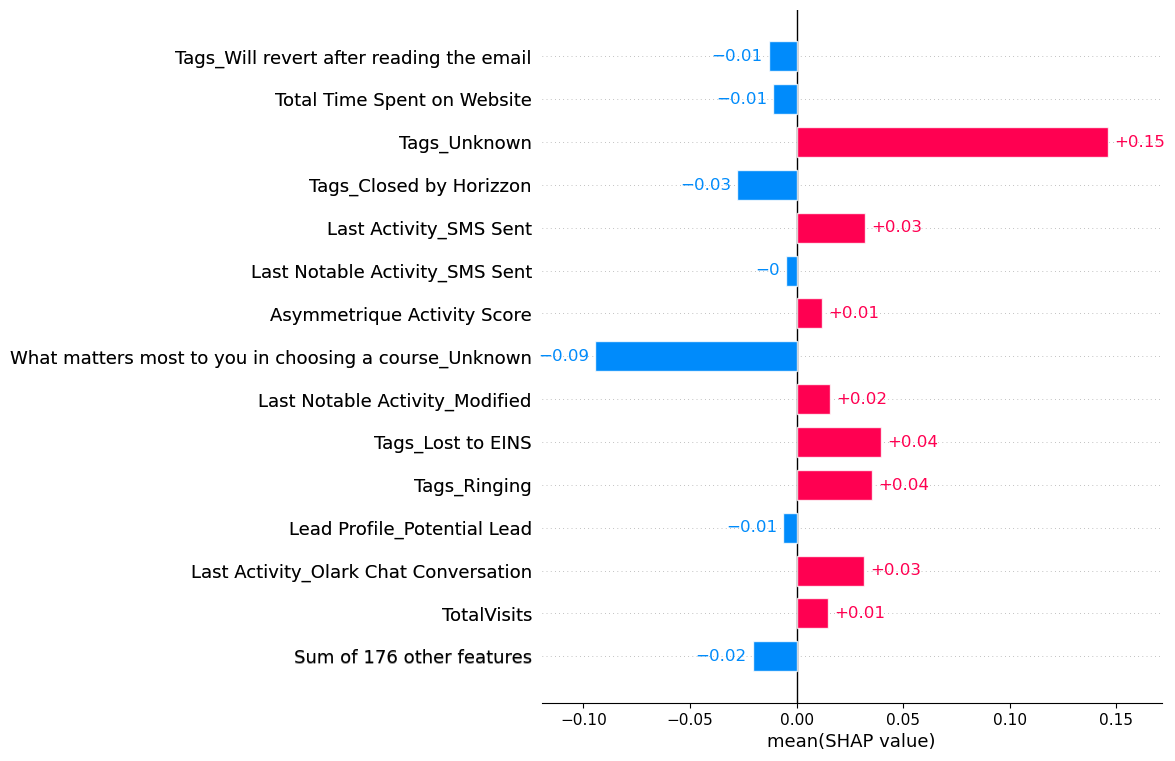

In [344]:
shap.plots.bar(shap_values.mean(0), max_display=15, order=shap_values.abs.mean(0))

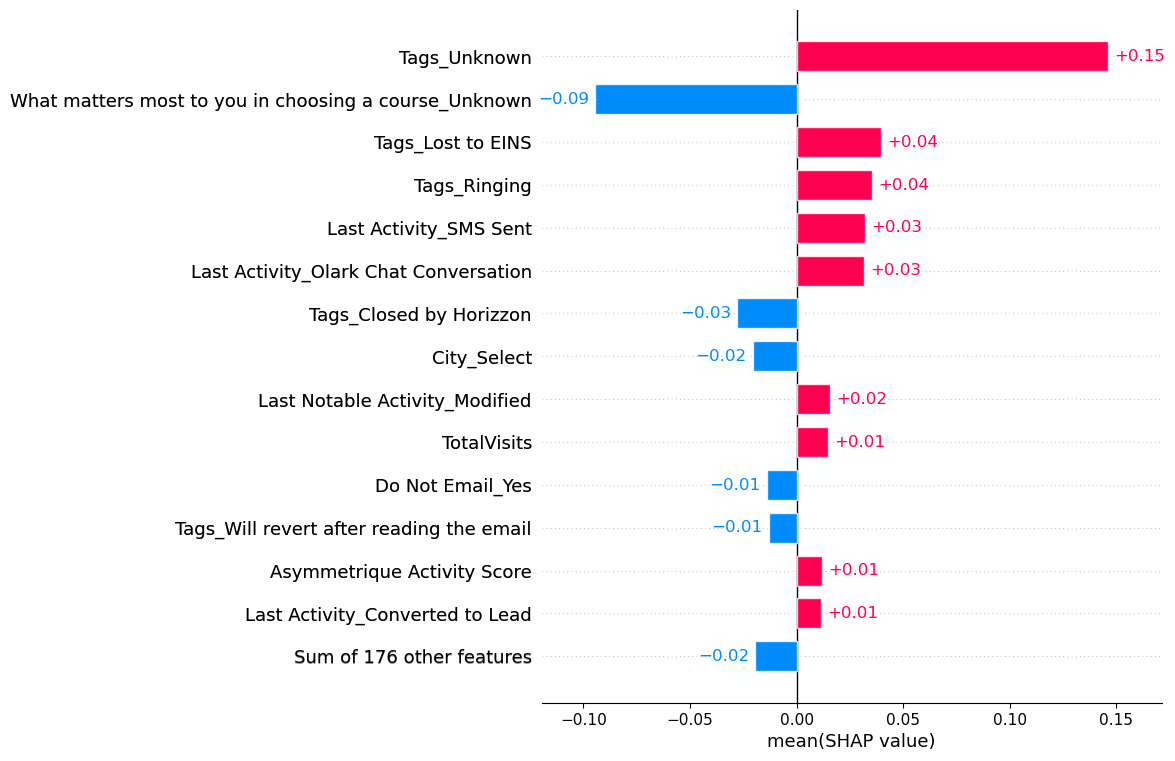

In [345]:
shap.plots.bar(shap_values.mean(0), max_display=15)

shap.plots.bar(shap_values.mean(0))
Orders features by mean SHAP (not abs mean SHAP)

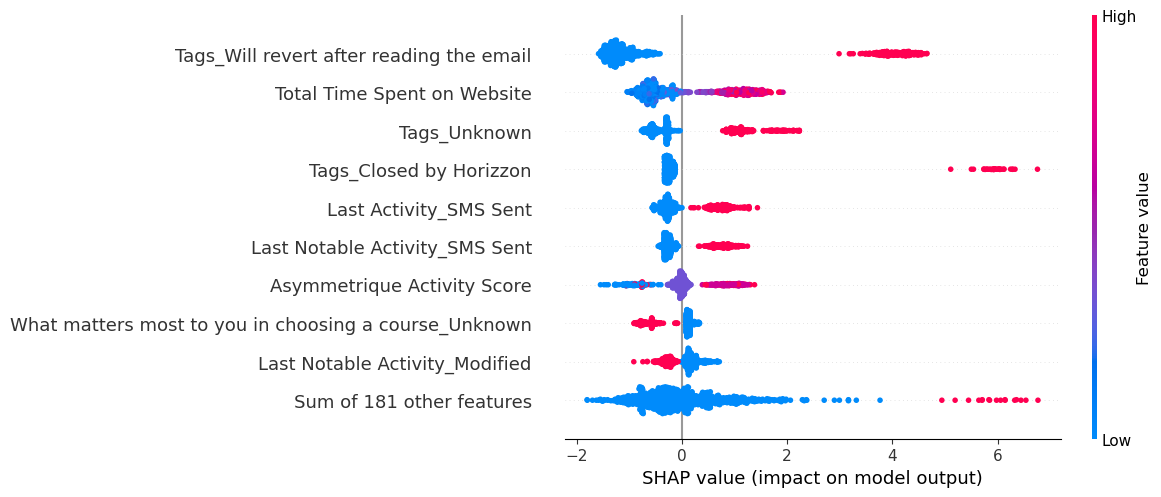

In [335]:
shap.plots.beeswarm(shap_values)

## 6) SHAP Validation:

In [336]:
shap_df = pd.DataFrame(shap_values.values, columns=X_test.columns)
shap_df

TotalVisits  Total Time Spent on Website  Page Views Per Visit  \
0      -0.019422                     1.345079              0.097390   
1      -0.007555                     1.232241              0.100123   
2       0.035686                     1.447793             -0.088206   
3       0.086791                     1.663734              0.117463   
4       0.239178                    -0.332079              0.002762   
..           ...                          ...                   ...   
919    -0.107842                    -0.596223              0.052938   
920     0.051827                     0.830860              0.014836   
921     0.025296                     0.878354              0.033497   
922    -0.066501                    -0.545535              0.079633   
923     0.035450                    -0.525051              0.123244   

     Asymmetrique Activity Score  Asymmetrique Profile Score  \
0                       0.108833                    0.003613   
1                       0.093653                    0.019337   
2                       1.059633                    0.020641   
3                      -0.866524                   -0.078544   
4                       0.751547                    0.052501   
..                           ...                         ...   
919                    -0.765814                    0.004250   
920                     0.120454                    0.013613   
921                     0.006827                    0.052235   
922                    -1.044921                   -0.015235   
923                    -0.019310                    0.034526   

     Lead Origin_Landing Page Submission  Lead Origin_Lead Add Form  \
0                               0.021552                   0.412577   
1                              -0.078674                  -0.016957   
2                              -0.024594                  -0.027181   
3                               0.027695                  -0.019519   
4                              -0.039128                  -0.020095   
..                                   ...                        ...   
919                             0.039444                  -0.067865   
920                            -0.064746                   0.333855   
921                            -0.078634                  -0.016876   
922                             0.038399                  -0.065140   
923                             0.037014                  -0.065876   

     Lead Origin_Lead Import  Lead Origin_Quick Add Form  \
0                        0.0                         0.0   
1                        0.0                         0.0   
2                        0.0                         0.0   
3                        0.0                         0.0   
4                        0.0                         0.0   
..                       ...                         ...   
919                      0.0                         0.0   
920                      0.0                         0.0   
921                      0.0                         0.0   
922                      0.0                         0.0   
923                      0.0                         0.0   

     Lead Source_Direct Traffic  Lead Source_Facebook  Lead Source_Google  \
0                      0.025751                   0.0           -0.001266   
1                      0.044094                   0.0           -0.002499   
2                      0.006610                   0.0           -0.014371   
3                      0.006454                   0.0           -0.014463   
4                      0.007610                   0.0            0.002976   
..                          ...                   ...                 ...   
919                    0.003469                   0.0            0.004511   
920                    0.001249                   0.0            0.001430   
921                    0.002932                   0.0           -0.006731   
922                    0.003760        

In [337]:
mean_shap = shap_df.mean().sort_values(ascending=False)
top_mean_shap = mean_shap.head(10).index.tolist()
top_mean_shap

['Tags_Unknown',
 'Tags_Lost to EINS',
 'Tags_Ringing',
 'Last Activity_SMS Sent',
 'Last Activity_Olark Chat Conversation',
 'Last Notable Activity_Modified',
 'TotalVisits',
 'Asymmetrique Activity Score',
 'Last Activity_Converted to Lead',
 'Asymmetrique Profile Score']

In [338]:
df_conv_rate = []

for feat in top_mean_shap:
    df_plot = (
    df_dum[["Converted", feat]]
    .groupby(feat)["Converted"]
    .mean()
    .reset_index()
    .rename(columns={feat: "Feature_Value", "Converted": "ConversionRate"})
    )
    
    df_plot["Feature"] = feat
    df_conv_rate.append(df_plot)

df_conv_rate = pd.concat(df_conv_rate, ignore_index=True)
df_conv_rate = df_conv_rate[["Feature", "Feature_Value", "ConversionRate"]]
df_conv_rate

Feature  Feature_Value  ConversionRate
0                            Tags_Unknown            0.0        0.462884
1                            Tags_Unknown            1.0        0.249329
2                       Tags_Lost to EINS            0.0        0.373966
3                       Tags_Lost to EINS            1.0        0.977143
4                            Tags_Ringing            0.0        0.438845
5                            Tags_Ringing            1.0        0.028263
6                  Last Activity_SMS Sent            0.0        0.282371
7                  Last Activity_SMS Sent            1.0        0.629144
8   Last Activity_Olark Chat Conversation            0.0        0.420588
9   Last Activity_Olark Chat Conversation            1.0        0.086331
10         Last Notable Activity_Modified            0.0        0.476256
11         Last Notable Activity_Modified            1.0        0.229821
12                            TotalVisits            0.0        0.418456
13                            TotalVisits            1.0        0.151899
14                            TotalVisits            2.0        0.319643
15                            TotalVisits            3.0        0.406098
16                            TotalVisits            4.0        0.400000
17                            TotalVisits            5.0        0.403576
18                            TotalVisits            6.0        0.381974
19                            TotalVisits            7.0        0.394822
20                            TotalVisits            8.0        0.459821
21                            TotalVisits            9.0        0.445122
22                            TotalVisits           10.0        0.500000
23                            TotalVisits           11.0        0.558140
24                            TotalVisits           12.0        0.400000
25                            TotalVisits           13.0        0.479167
26                            TotalVisits           14.0        0.583333
27                            TotalVisits           15.0        0.388889
28                            TotalVisits           16.0        0.476190
29                            TotalVisits           17.0        0.125000
30                            TotalVisits           18.0        0.400000
31                            TotalVisits           19.0        0.666667
32                            TotalVisits           20.0        0.333333
33                            TotalVisits           21.0        0.833333
34                            TotalVisits           22.0        0.333333
35                            TotalVisits           23.0        0.500000
36                            TotalVisits           24.0        0.800000
37                            TotalVisits           25.0        0.200000
38                            TotalVisits           26.0        1.000000
39                            TotalVisits           27.0        0.600000
40                            TotalVisits           28.0        0.000000
41                            TotalVisits           29.0        0.000000
42                            TotalVisits           30.0        0.000000
43                            TotalVisits           32.0        0.000000
44                            TotalVisits           41.0        0.000000
45                            TotalVisits           42.0        0.000000
46                            TotalVisits           43.0        0.000000
47                            TotalVisits           54.0        0.000000
48                            TotalVisits           55.0        0.000000
49                            TotalVisits           74.0        0.000000
50                            TotalVisits          115.0        0.000000
51                            TotalVisits          141.0        0.000000
52                            TotalVisits          251.0        1.000000
53            Asymmetrique Activity Score            7.0        0.000000
54            Asymm

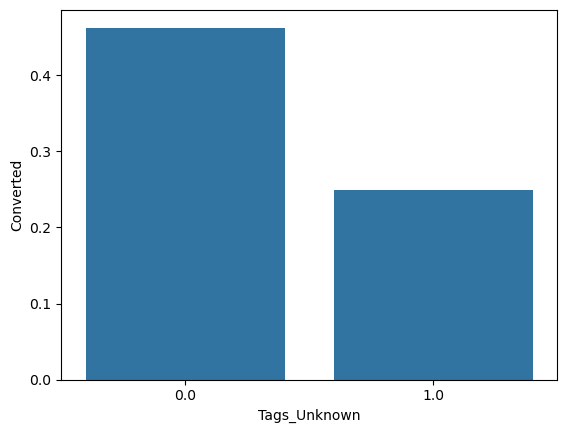

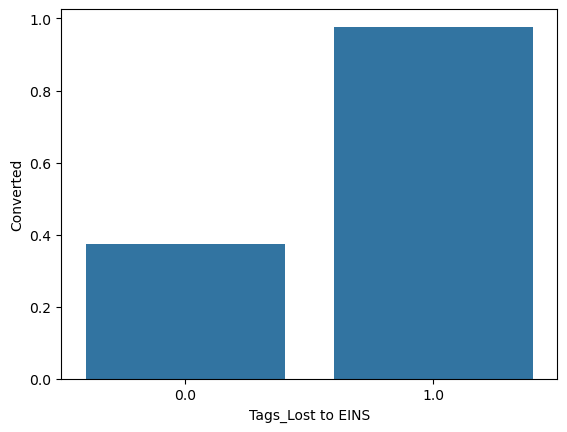

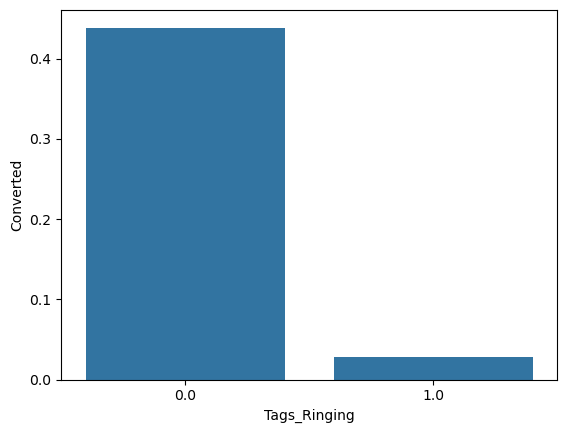

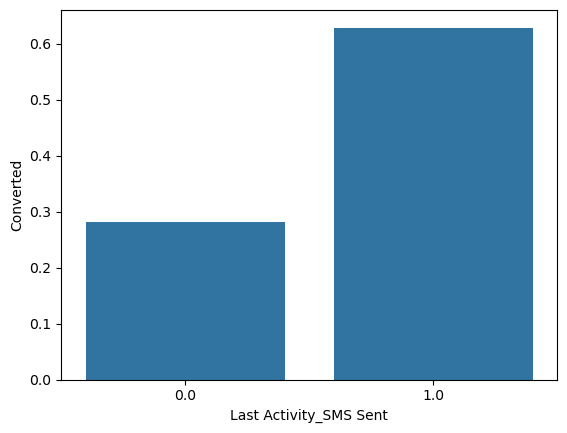

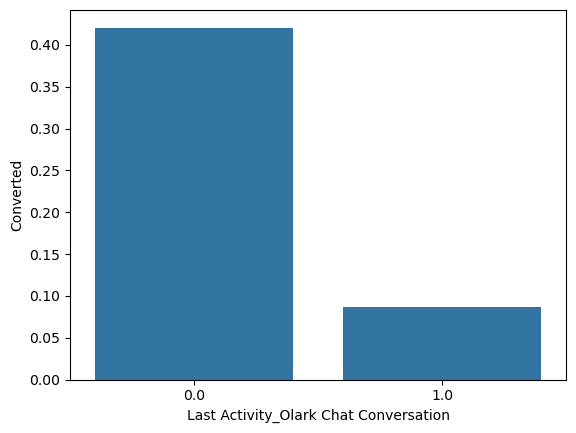

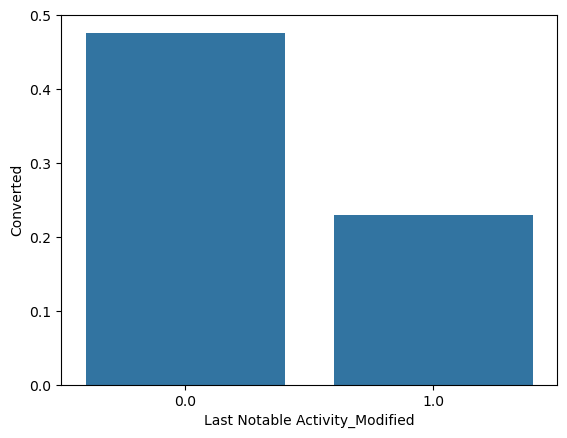

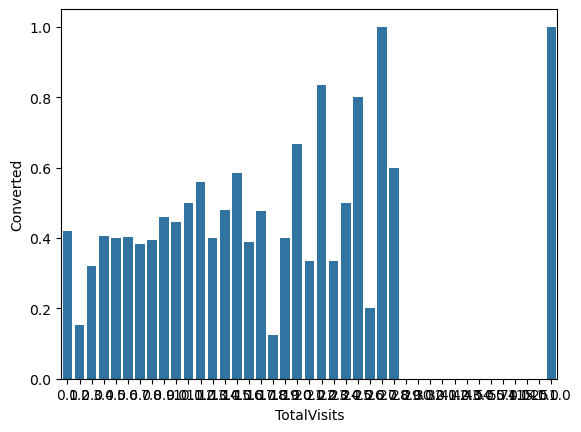

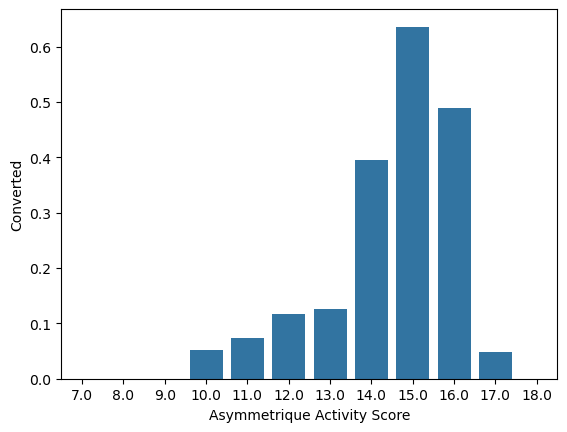

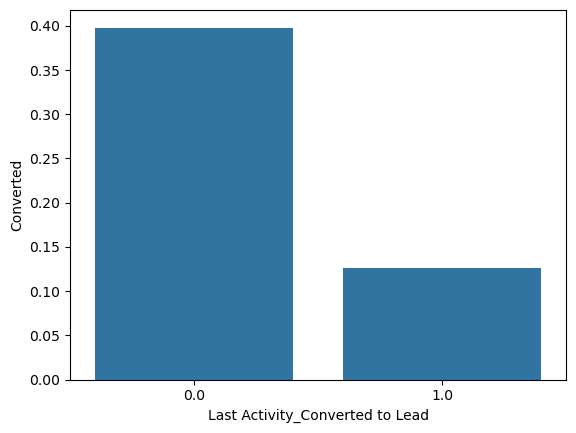

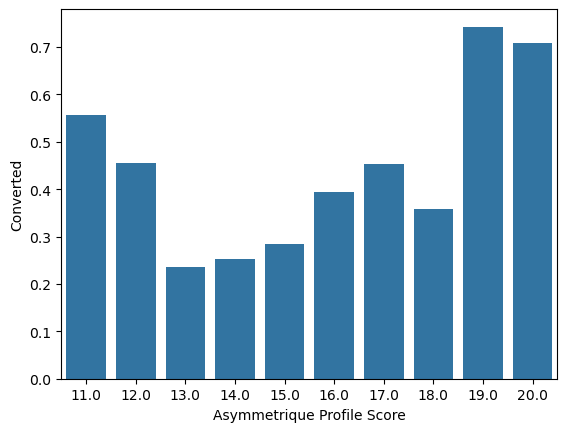

In [339]:
# df_top_features_dum is the original dummy dataset prior to x and y segmentation.

for top in top_mean_shap:
    df_plot = df_dum.loc[:,["Converted", top]]

    df_plot = df_plot.groupby(top).mean().reset_index()

    sns.barplot(df_plot, x=top, y='Converted')
    plt.show()
    

### 6.2) Check for colineality - Important for later SHAP Analysis:

I will test if there is colineality between variables:

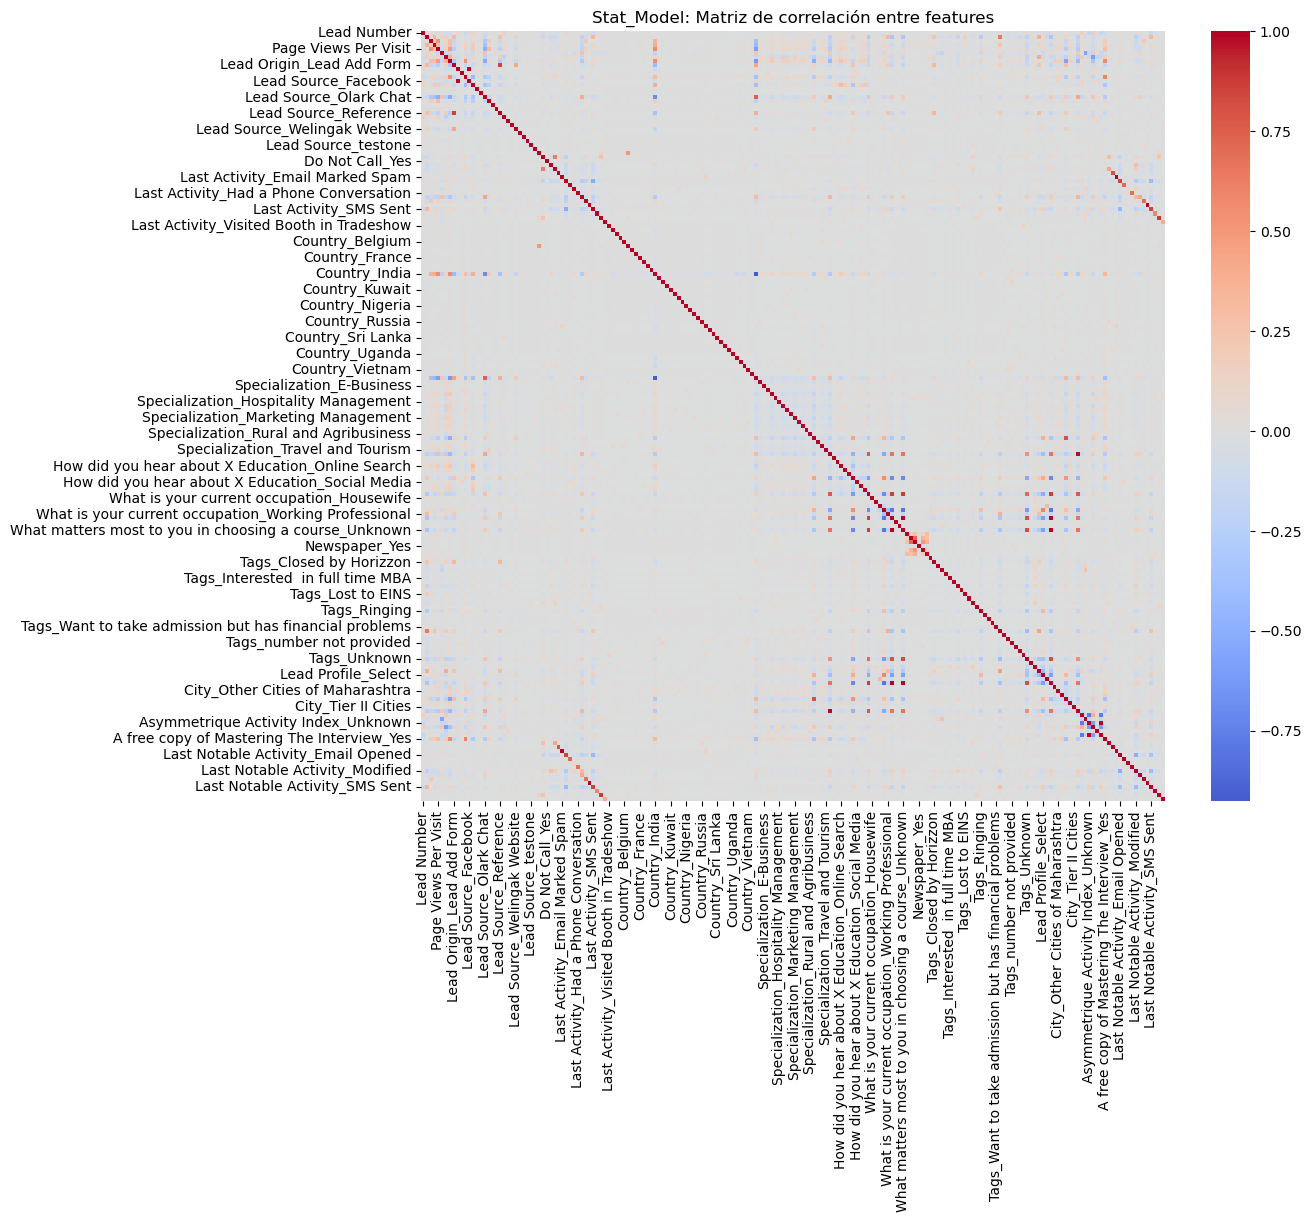

In [402]:
# Calculás la correlación
corr_matrix = df_dum.corr()

# Visualizás
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, cmap="coolwarm", center=0, annot=False)
plt.title("Stat_Model: Matriz de correlación entre features")
plt.show()

In [403]:
import numpy as np

# Absolute correlation matrix:
corr_matrix = df_dum.corr().abs()

# I want only the upper half:
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
# This code generates a matrix of 1/0 that will act as a mask, like an idx.

# np.ones(corr_magtrix.shaope) -> Creates a matrix of 1's.
# np.triu is a function that selects the "TRIangular Upper", k=1 is used to exclude principal diagonal.

# .astype(bool) transforms to boolean.

# Find columns with high correlation.
high_corr = [column for column in upper.columns if any(upper[column] > 0.80)]


print("Features with high correlation:", high_corr)


Features with high correlation: ['Lead Source_Facebook', 'Lead Source_Reference', 'Country_Unknown', 'What is your current occupation_Unknown', 'What matters most to you in choosing a course_Unknown', 'Tags_Unknown', 'Lead Profile_Unknown', 'City_Select', 'City_Unknown', 'Asymmetrique Profile Index_Unknown', 'Last Notable Activity_Email Link Clicked', 'Last Notable Activity_Email Marked Spam', 'Last Notable Activity_Email Opened', 'Last Notable Activity_Resubscribed to emails', 'Last Notable Activity_SMS Sent', 'Last Notable Activity_Unsubscribed']


In [251]:
# To find the pairs of correlated features::

In [404]:
threshold = 0.80
corr_pairs = (
    upper.stack()
    .reset_index()
    .rename(columns={'level_0': 'Feature_1', 'level_1': 'Feature_2', 0: 'Correlation'})
)

# Filtrar solo los pares con correlación alta
high_corr_pairs = corr_pairs[corr_pairs['Correlation'] > threshold]

pd.set_option('display.max_colwidth', 80)
pd.set_option('display.max_colwidth', 80)
high_corr_pairs.sort_values(by="Correlation", ascending=False)

Feature_1  \
18148                    Asymmetrique Activity Index_Unknown   
16095  What matters most to you in choosing a course_Unknown   
6388                         Last Activity_Email Marked Spam   
7453                    Last Activity_Resubscribed to emails   
15891                What is your current occupation_Unknown   
15853                What is your current occupation_Unknown   
1685                                 Lead Origin_Lead Import   
14658                                 Specialization_Unknown   
9715                                           Country_India   
7894                              Last Activity_Unsubscribed   
15418             How did you hear about X Education_Unknown   
15456             How did you hear about X Education_Unknown   
15415             How did you hear about X Education_Unknown   
1511                               Lead Origin_Lead Add Form   
7601                                  Last Activity_SMS Sent   
6543                              Last Activity_Email Opened   
16089  What matters most to you in choosing a course_Unknown   
17711                                           Tags_Unknown   
15885                What is your current occupation_Unknown   
14305                                  Specialization_Select   
6232                        Last Activity_Email Link Clicked   

                                                   Feature_2  Correlation  
18148                     Asymmetrique Profile Index_Unknown     1.000000  
16095                                   Lead Profile_Unknown     1.000000  
6388                 Last Notable Activity_Email Marked Spam     1.000000  
7453            Last Notable Activity_Resubscribed to emails     1.000000  
15891                                   Lead Profile_Unknown     0.995041  
15853  What matters most to you in choosing a course_Unknown     0.995041  
1685                                    Lead Source_Facebook     0.981709  
14658                                           City_Unknown     0.980988  
9715                                         Country_Unknown     0.926091  
7894                      Last Notable Activity_Unsubscribed     0.877108  
15418  What matters most to you in choosing a course_Unknown     0.869794  
15456                                   Lead Profile_Unknown     0.869794  
15415                What is your current occupation_Unknown     0.863513  
1511                                   Lead Source_Reference     0.853237  
7601                          Last Notable Activity_SMS Sent     0.852707  
6543                      Last Notable Activity_Email Opened     0.842496  
16089                                           Tags_Unknown     0.813335  
17711                                   Lead Profile_Unknown     0.813335  
15885                                           Tags_Unknown     0.809020  
14305                                            City_Select     0.806119  
6232                Last Notable Activity_Email Link Clicked     0.800764

**Crtieria for correlated feature drop:**
1. **Lead-specific relevance**
Retain features that are more directly associated with the lead's behavior or profile, especially if they reflect explicit actions or attributes provided by the user.
2. **Informational value**
If one of the features represents a missing or unknown value (e.g., _Unknown), and the other provides concrete or more detailed information, prefer keeping the more informative feature.
3. **Interpretability**
Favor features that are easier to interpret and communicate to non-technical stakeholders, such as marketing teams. Simple, self-explanatory features contribute more to actionable insights.

In [405]:
to_drop = ['Last Activity_Email Marked Spam',
          'Last Activity_Resubscribed to emails',
          'Lead Profile_Unknown',
          'Asymmetrique Profile Index_Unknown',
          'What is your current occupation_Unknown',
           'Country_Unknown',
           'City_Unknown',
           'Last Activity_Unsubscribed',
           'How did you hear about X Education_Unknown',
           'Lead Origin_Lead Import',
           'Lead Origin_Lead Add Form',
           'Last Activity_SMS Sent',
           'Tags_Unknown',
           'Last Activity_Email Opened',
           'City_Select',
           'Last Activity_Email Link Clicked'
          ]

In [406]:
df_dum_2 = df_dum.drop(to_drop, axis=1)

In [407]:
df_dum.shape

(9240, 192)

In [408]:
df_dum_2.shape

(9240, 176)

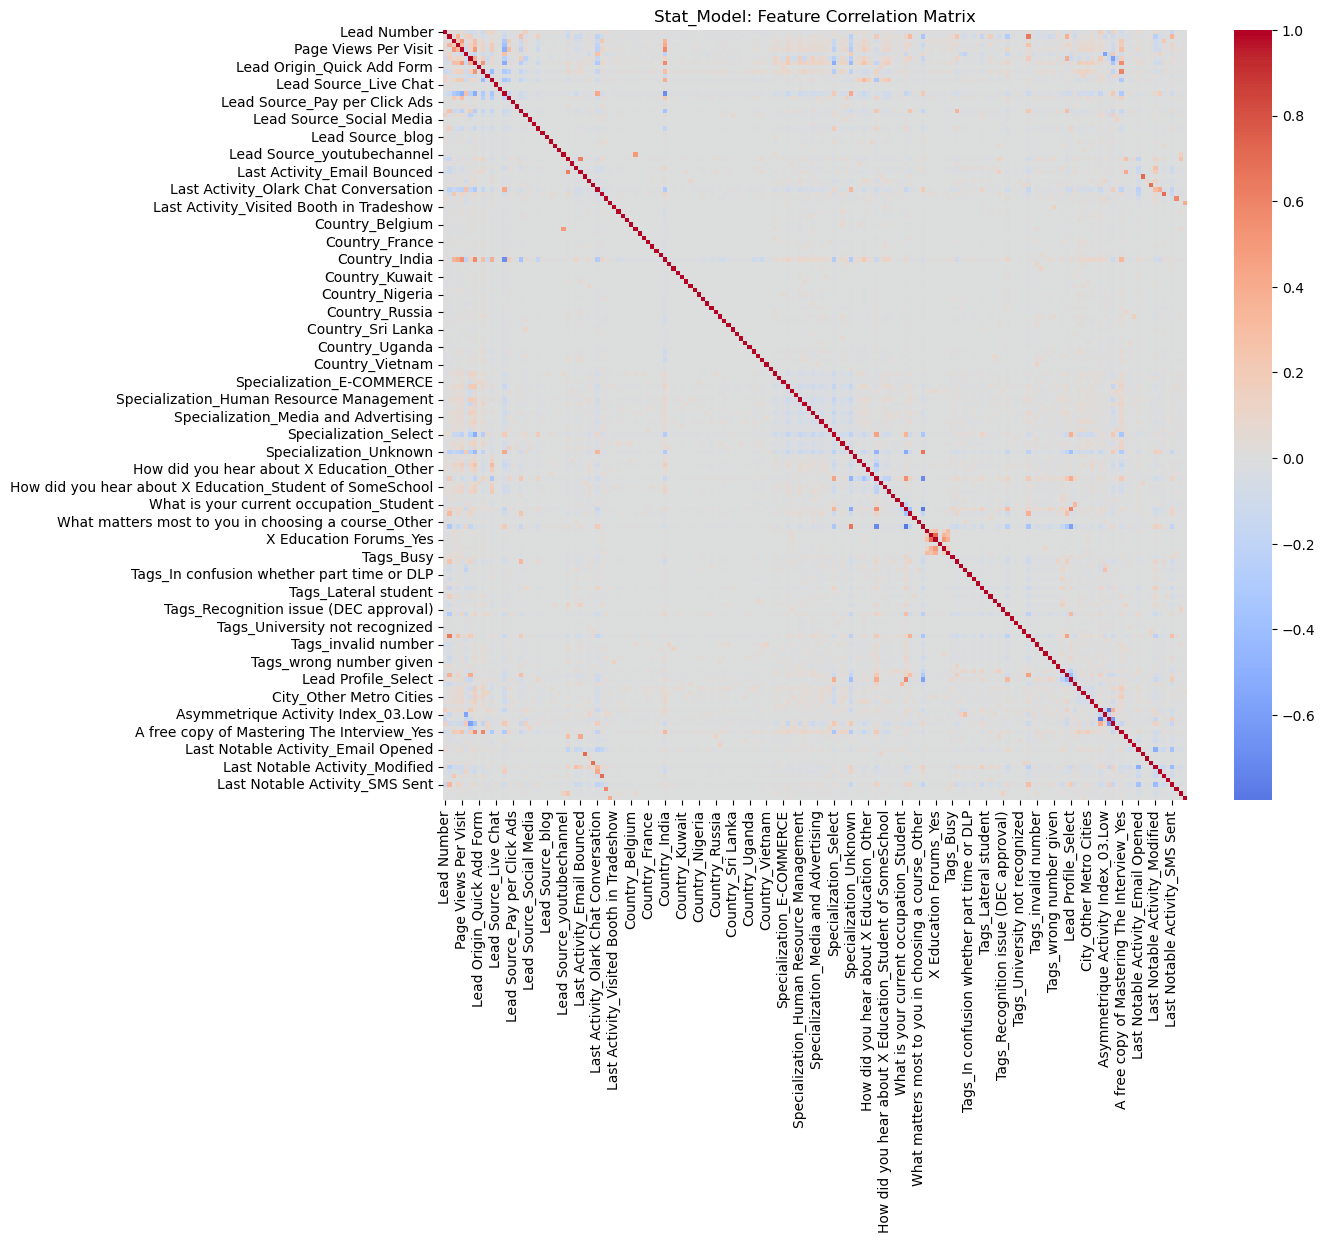

In [409]:
# Calculás la correlación
corr_matrix = df_dum_2.corr()

# Visualizás
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, cmap="coolwarm", center=0, annot=False)
plt.title("Stat_Model: Feature Correlation Matrix")
plt.show()

In [410]:
# Absolute correlation matrix:
corr_matrix = df_dum_2.corr().abs()

upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

high_corr = [column for column in upper.columns if any(upper[column] > 0.85)]


print("Features with high correlation:", high_corr)


Features with high correlation: []


## 6) Check if colineality affects Model Performance and SHAP Analysis:

In [411]:
# Split the data:

y_data = df_dum_2["Converted"]
X_data = df_dum_2.drop(columns =["Converted","Lead Number"])


X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, test_size=0.1, stratify=y_data,  random_state=123)

In [412]:
X_train.shape[0]+X_test.shape[0]

9240

In [413]:
n = int(len(X_train)*0.8)
n

# I will use the 80% of the train data to train the model, the 20% to evaluate the model in each round.

6652

In [414]:
# So I will selectt the first n examples for the X_train_fit and the from n onwards as the X_train_eval

X_train_fit, X_train_eval, y_train_fit, y_train_eval = X_train[:n], X_train[n:], y_train[:n], y_train[n:]

In [415]:
from xgboost import XGBClassifier

In [416]:
# Now I define the model:
xgb_model_2 = XGBClassifier(n_estimators=500, 
                          learning_rate = 0.1, 
                          early_stopping_rounds=10, 
                          eval_metric="logloss",
                          random_state = 123)
# Train the model:
xgb_model_2.fit(X_train_fit, 
              y_train_fit, 
              eval_set=[(X_train_eval, y_train_eval)], 
              verbose=True)

[0]	validation_0-logloss:0.59913
[1]	validation_0-logloss:0.54472
[2]	validation_0-logloss:0.50043
[3]	validation_0-logloss:0.46346
[4]	validation_0-logloss:0.43200
[5]	validation_0-logloss:0.40537
[6]	validation_0-logloss:0.38126
[7]	validation_0-logloss:0.36060
[8]	validation_0-logloss:0.34283
[9]	validation_0-logloss:0.32555
[10]	validation_0-logloss:0.31176
[11]	validation_0-logloss:0.29833
[12]	validation_0-logloss:0.28624
[13]	validation_0-logloss:0.27527
[14]	validation_0-logloss:0.26572
[15]	validation_0-logloss:0.25756
[16]	validation_0-logloss:0.24998
[17]	validation_0-logloss:0.24323
[18]	validation_0-logloss:0.23663
[19]	validation_0-logloss:0.23082
[20]	validation_0-logloss:0.22573
[21]	validation_0-logloss:0.22125
[22]	validation_0-logloss:0.21741
[23]	validation_0-logloss:0.21329
[24]	validation_0-logloss:0.20984
[25]	validation_0-logloss:0.20628
[26]	validation_0-logloss:0.20335
[27]	validation_0-logloss:0.20098
[28]	validation_0-logloss:0.19877
[29]	validation_0-loglos

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=10,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.1, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=500,
              n_jobs=None, num_parallel_tree=None, random_state=123, ...)

In [417]:
xgb_model_2.best_iteration

142

The best round of training was round 117, with a log loss of 0.16224

(As early_stopping_roundswas set to 10, after the 10th round where the log loss doesn't improve, training stops.)

### 6.1) 2nd Model Evaluation:

I want to evaluate the model for having a high sensivility (find the most of the converted leads), but also having a low proportion of False + (i.e. I want to have high Precision). So I will evaluate the F1-Score which is a Harmonic Mean between both metrics. 

To analyze Bias and Variance I will evaluate only F1-Score.

In [418]:
from sklearn.metrics import f1_score 
from sklearn.metrics import precision_score, recall_score

In [419]:
print(f"F1-Score for Train Set is {f1_score(xgb_model_2.predict(X_train), y_train):.4f}")
print(f"F1-Score for Test Set is {f1_score(xgb_model_2.predict(X_test), y_test):.4f}")

print(f"Precision for Train Set is {precision_score(xgb_model_2.predict(X_train), y_train):.4f}")
print(f"Precision for Test Set is {precision_score(xgb_model_2.predict(X_test), y_test):.4f}")

print(f"Recall for Train Set is {recall_score(xgb_model_2.predict(X_train), y_train):.4f}")
print(f"Recall for Test Set is {recall_score(xgb_model_2.predict(X_test), y_test):.4f}")

F1-Score for Train Set is 0.9405
F1-Score for Test Set is 0.9226
Precision for Train Set is 0.9251
Precision for Test Set is 0.9045
Recall for Train Set is 0.9565
Recall for Test Set is 0.9415


- The performance of the model is very high, as the F1-score for the test set reaches 0.9405, indicating a strong balance between precision and recall.
- Additionally, the small gap between the F1-scores of the training (0.9405) and test (0.9226) sets suggests that there is no evidence of overfitting — the model generalizes well.
- When analyzing precision and recall separately, we observe that both metrics are consistently high across training and test sets. This implies that the model is able to identify a large proportion of converting leads (recall = 0.9415 on test), while maintaining a high proportion of true positives among its positive predictions (precision = 0.9045 on test).

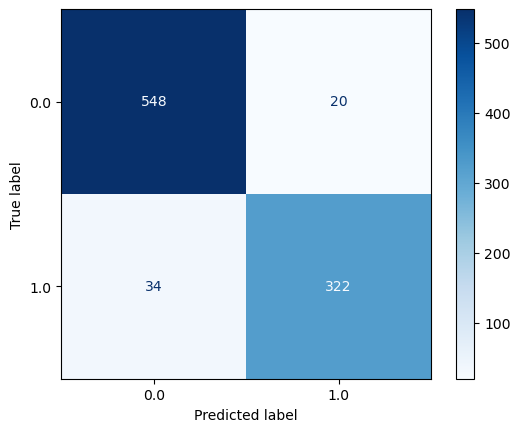

In [420]:
from sklearn.metrics import ConfusionMatrixDisplay 

predictions = xgb_model_2.predict(X_test)
disp = ConfusionMatrixDisplay.from_predictions(
    y_pred=predictions, 
    y_true=y_test,
    cmap='Blues'
)

plt.show()

In [421]:
import shap

explainer = shap.Explainer(xgb_model_2, X_train)
shap_values = explainer(X_test)

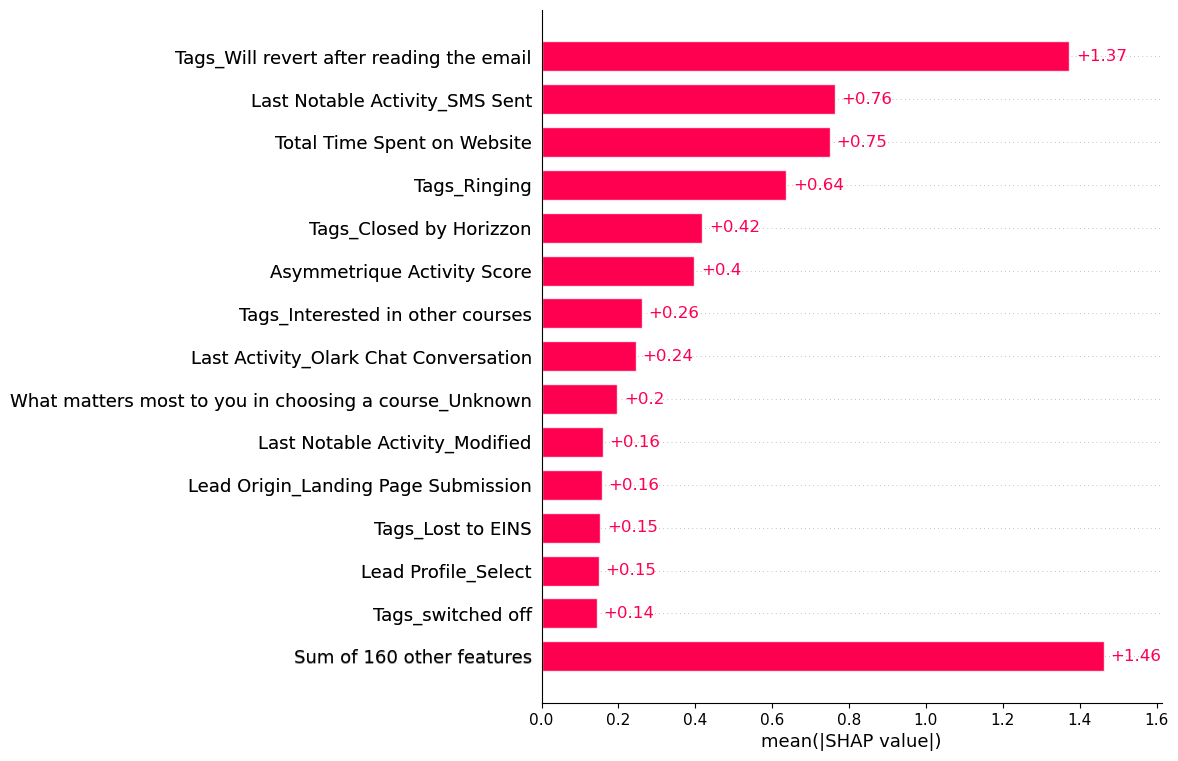

In [422]:
shap.plots.bar(shap_values, max_display=15)

This plot shows the average of the absolute SHAP values for each feature. It is a measure of the feature importance on the prediction. As the absolute values are used, this plot doesn't show if the feature affects pushing up or down the prediction. The plot below will use this to organize the features in order of importance.

The plot show that 

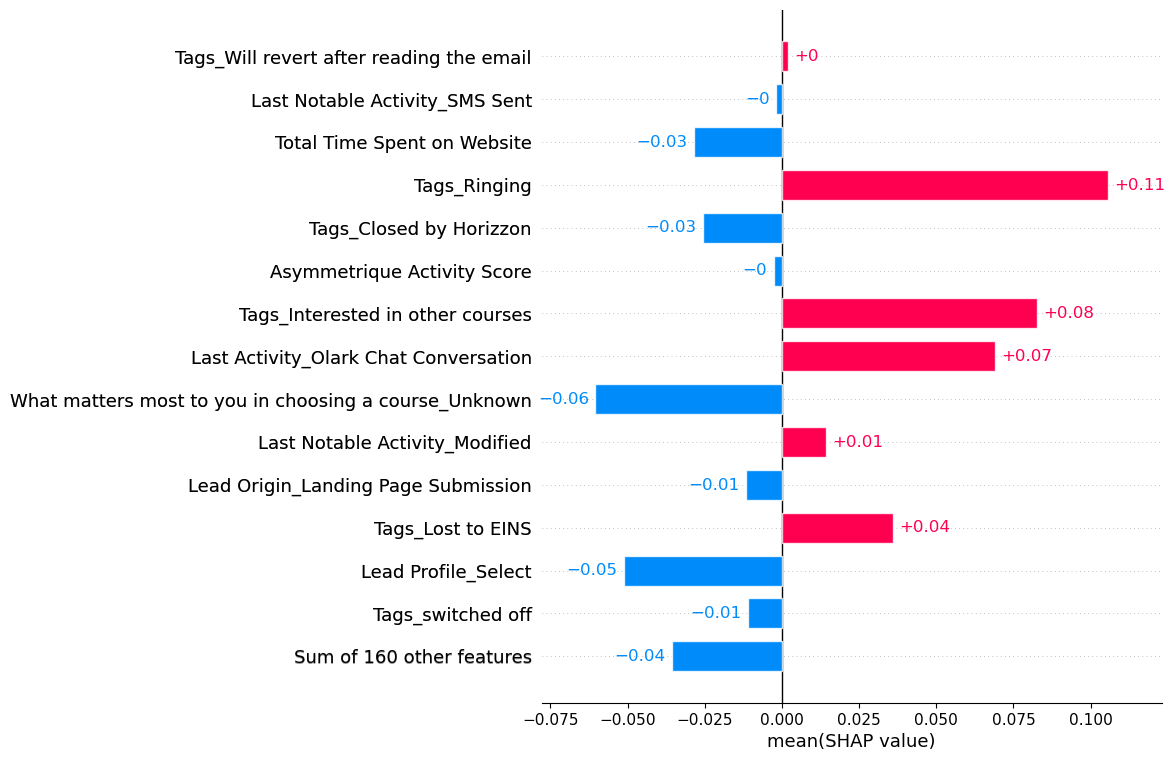

In [423]:
shap.plots.bar(shap_values.mean(0), max_display=15, order=shap_values.abs.mean(0))

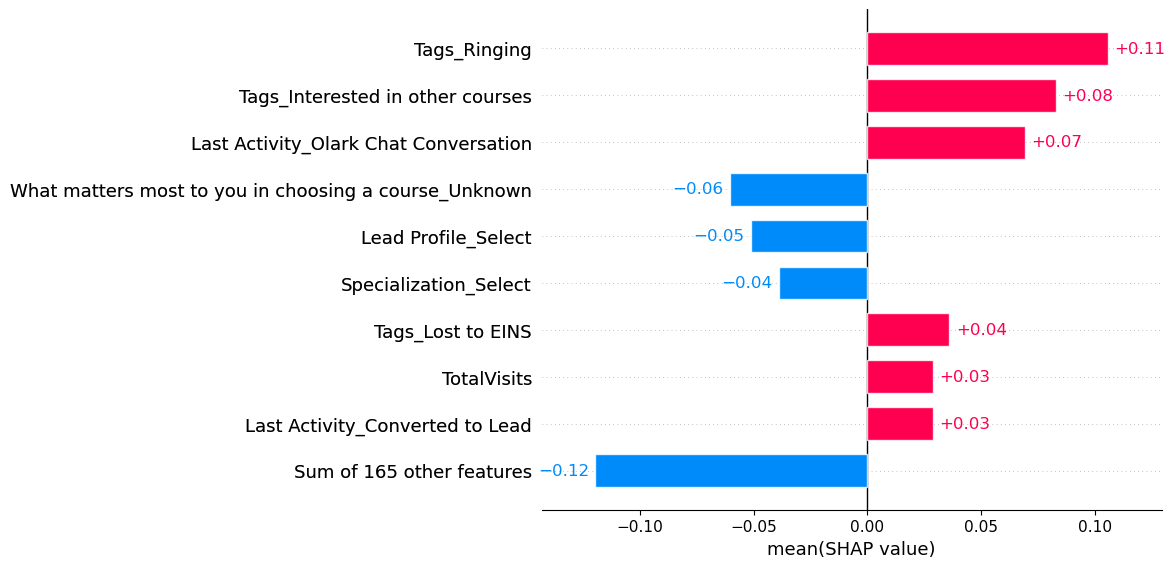

In [424]:
shap.plots.bar(shap_values.mean(0), max_display=10)

shap.plots.bar(shap_values.mean(0))
Orders features by mean SHAP (not abs mean SHAP)

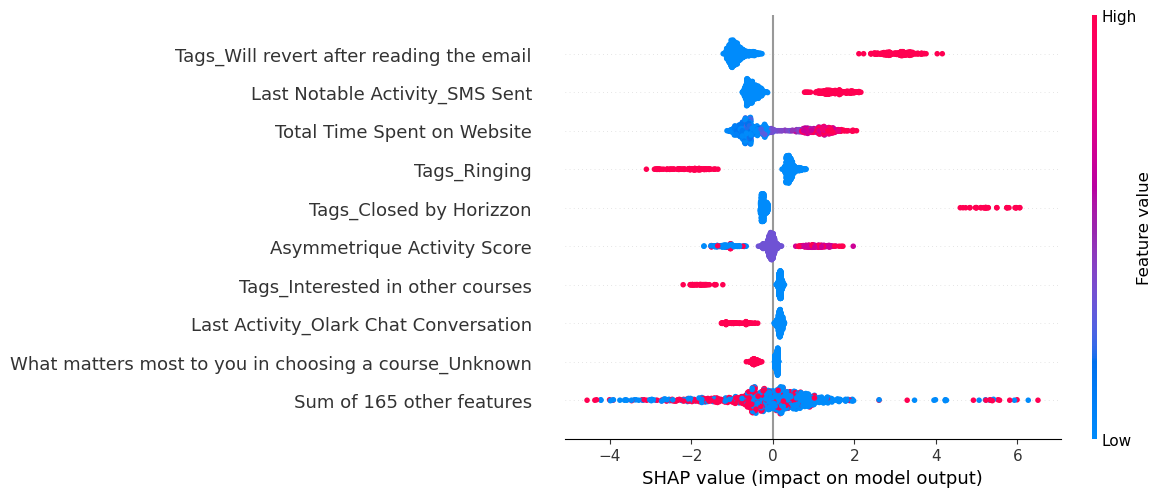

In [425]:
shap.plots.beeswarm(shap_values)

In [426]:
shap_df = pd.DataFrame(shap_values.values, columns=X_test.columns)
shap_df

TotalVisits  Total Time Spent on Website  Page Views Per Visit  \
0       0.035994                     1.416446              0.207798   
1       0.032677                     1.463690              0.177301   
2       0.066122                     1.329271             -0.171909   
3       0.149842                     1.443423              0.101043   
4       0.305593                    -0.326706              0.076042   
..           ...                          ...                   ...   
919    -0.019802                    -0.650808              0.007448   
920     0.029844                     0.886766              0.059859   
921     0.053229                     0.988028              0.178553   
922     0.007913                    -0.611934             -0.035701   
923     0.150796                    -0.539475              0.056587   

     Asymmetrique Activity Score  Asymmetrique Profile Score  \
0                       0.165752                    0.015905   
1                       0.117057                    0.030981   
2                       1.144989                    0.032825   
3                      -1.168820                   -0.064829   
4                       0.885080                    0.075038   
..                           ...                         ...   
919                    -1.041004                    0.003663   
920                     0.050685                    0.029128   
921                    -0.002398                    0.075703   
922                    -1.508332                   -0.030732   
923                    -0.021186                    0.061400   

     Lead Origin_Landing Page Submission  Lead Origin_Quick Add Form  \
0                               0.250541                         0.0   
1                               0.106956                         0.0   
2                              -0.113140                         0.0   
3                               0.116015                         0.0   
4                              -0.118821                         0.0   
..                                   ...                         ...   
919                             0.076665                         0.0   
920                             0.130853                         0.0   
921                            -0.152524                         0.0   
922                             0.116130                         0.0   
923                             0.167478                         0.0   

     Lead Source_Direct Traffic  Lead Source_Facebook  Lead Source_Google  \
0                      0.008567                   0.0           -0.065153   
1                      0.005178                   0.0           -0.004387   
2                     -0.001854                   0.0            0.028573   
3                      0.024363                   0.0           -0.021000   
4                      0.001573                   0.0           -0.003087   
..                          ...                   ...                 ...   
919                    0.002907                   0.0           -0.002841   
920                    0.007465                   0.0           -0.016817   
921                    0.005985                   0.0            0.009420   
922                    0.002951                   0.0           -0.003492   
923                    0.002951                   0.0           -0.003658   

     Lead Source_Live Chat  Lead Source_NC_EDM  Lead Source_Olark Chat  \
0                      0.0                 0.0                0.003157   
1                      0.0                 0.0                0.002741   
2                      0.0                 0.0                0.001171   
3                      0.0                 0.0                0.025972   
4                      0.0                 0.0                0.000882   
..                     ...                 ...                     ...   
919                    0.0                 0.0                0.005913   
9

In [427]:
mean_shap = shap_df.mean(0).sort_values(ascending=False)
top_mean_shap_positive = mean_shap.head(3).index.tolist()
top_mean_shap_negative = mean_shap.tail(3).index.tolist()[::-1]
top_mean_shap_negative

['What matters most to you in choosing a course_Unknown',
 'Lead Profile_Select',
 'Specialization_Select']

### Positive Weight on Prediciton:

In [428]:
df_conv_rate = []

for feat in top_mean_shap_positive:
    df_plot = (
    df_dum_2[["Converted", feat]]
    .groupby(feat)["Converted"]
    .mean()
    .reset_index()
    .rename(columns={feat: "Feature_Value", "Converted": "ConversionRate"})
    )
    
    df_plot["Feature"] = feat
    df_conv_rate.append(df_plot)

df_conv_rate = pd.concat(df_conv_rate, ignore_index=True)
df_conv_rate = df_conv_rate[["Feature", "Feature_Value", "ConversionRate"]]
df_conv_rate

Feature  Feature_Value  ConversionRate
0                           Tags_Ringing            0.0        0.438845
1                           Tags_Ringing            1.0        0.028263
2       Tags_Interested in other courses            0.0        0.406554
3       Tags_Interested in other courses            1.0        0.025341
4  Last Activity_Olark Chat Conversation            0.0        0.420588
5  Last Activity_Olark Chat Conversation            1.0        0.086331

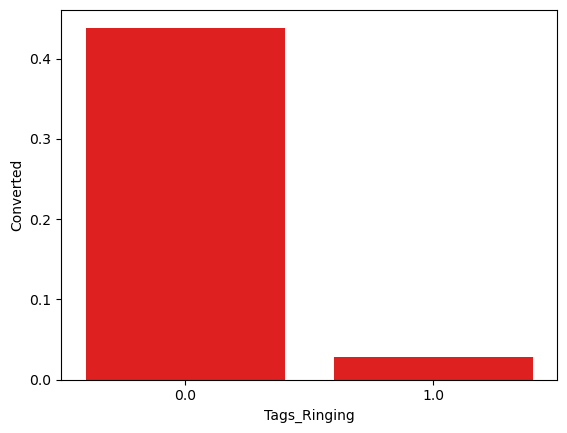

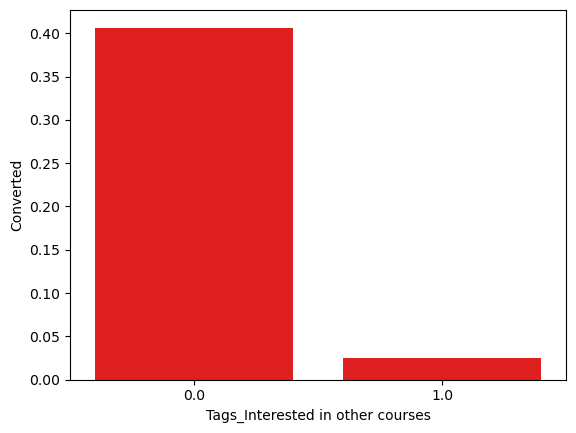

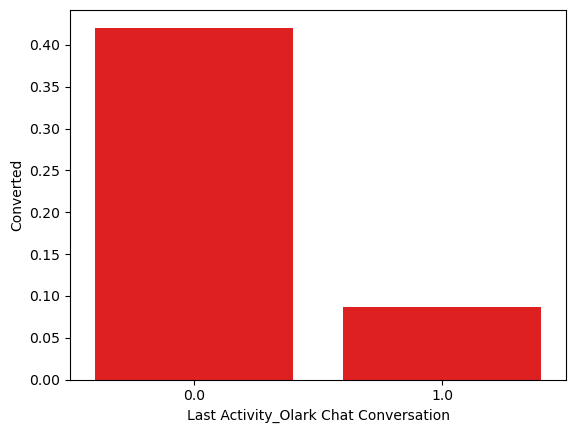

In [513]:
# df_top_features_dum is the original dummy dataset prior to x and y segmentation.

for top in top_mean_shap_positive:
    df_plot = df_dum.loc[:,["Converted", top]]

    df_plot = df_plot.groupby(top).mean().reset_index()

    sns.barplot(df_plot, x=top, y='Converted', color='red')
    plt.show()
    

### Negative Weight on Prediciton:

In [430]:
df_conv_rate = []

for feat in top_mean_shap_negative:
    df_plot = (
    df_dum_2[["Converted", feat]]
    .groupby(feat)["Converted"]
    .mean()
    .reset_index()
    .rename(columns={feat: "Feature_Value", "Converted": "ConversionRate"})
    )
    
    df_plot["Feature"] = feat
    df_conv_rate.append(df_plot)

df_conv_rate = pd.concat(df_conv_rate, ignore_index=True)
df_conv_rate = df_conv_rate[["Feature", "Feature_Value", "ConversionRate"]]
df_conv_rate

Feature  Feature_Value  \
0  What matters most to you in choosing a course_Unknown            0.0   
1  What matters most to you in choosing a course_Unknown            1.0   
2                                    Lead Profile_Select            0.0   
3                                    Lead Profile_Select            1.0   
4                                  Specialization_Select            0.0   
5                                  Specialization_Select            1.0   

   ConversionRate  
0        0.488593  
1        0.136582  
2        0.366902  
3        0.408104  
4        0.375856  
5        0.421215

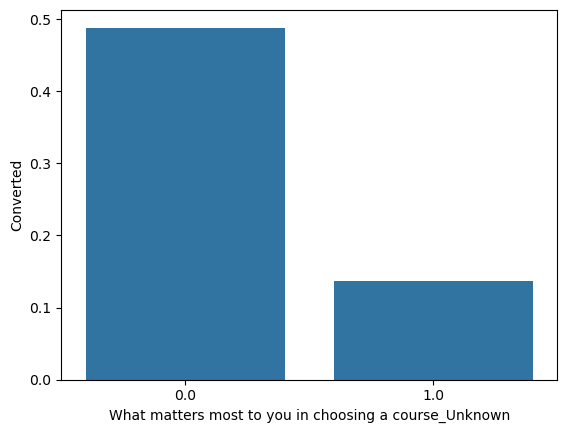

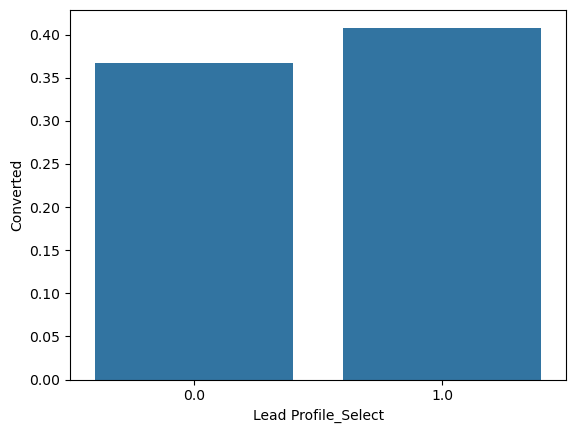

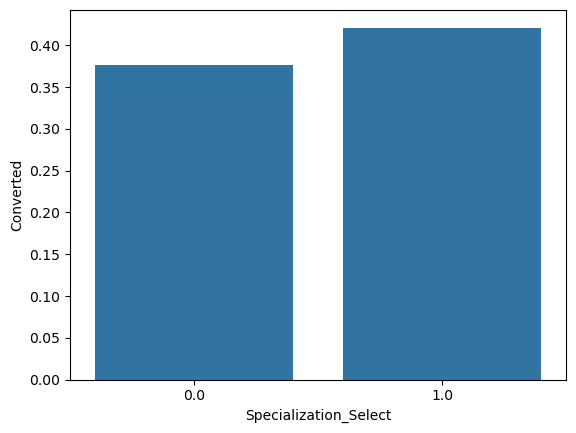

In [515]:
# df_top_features_dum is the original dummy dataset prior to x and y segmentation.

for top in top_mean_shap_negative:
    df_plot = df_dum.loc[:,["Converted", top]]

    df_plot = df_plot.groupby(top).mean().reset_index()

    sns.barplot(df_plot, x=top, y='Converted')
    plt.show()
    

## SHAP Conclusions:

1. The model predicts well, but doesn't always explain clearly.
Although the XGBoost model shows strong predictive performance, some features have SHAP values that contradict their actual conversion rates, especially among categorical dummies like Tags_*.

2. Highly correlated features are diluting each other's explanatory power.
For instance, after removing Tags_Unknown—which was highly correlated with What matters most to you..._Unknown—SHAP values became more aligned with the actual data. This suggests the model is spreading importance across similar variables, making interpretation more difficult for this complex dataset.

3. Some features with positive SHAP values are associated with low conversion rates.
This indicates that the model may be learning indirect or spurious patterns, or that the feature’s effect is conditional on other variables, which SHAP captures but is hard to unpack without deeper context.

4. SHAP is powerful but complex to interpret with many dummies and collinearity.
While SHAP provides detailed insights into how each feature contributes to each prediction, it is not always intuitive or directly actionable, especially for communicating insights to business stakeholders.

5. Validation with data anlysis is very important when using SHAP.

## 7) Explainable Boosting Machine (EBM):

The Explainable Boosting Machine (EBM) is an interpretable machine learning model based on Generalized Additive Models (GAMs).  
It builds separate shape functions for each feature, capturing non-linear relationships while maintaining transparency in how predictions are made.

Unlike black-box models such as XGBoost, EBM is designed to be human-interpretable by default, which makes it especially useful in business contexts where model transparency and trust are important.

### Limitations of the EBM Model

While the Explainable Boosting Machine (EBM) provides strong interpretability and competitive performance, it also has some limitations that should be considered:

- **Limited Interaction Modeling**: By default, EBM captures only pairwise interactions (if enabled) and may miss complex multivariate interactions that models like XGBoost can learn more effectively.
- **Feature Independence Assumption**: The additive nature of EBM assumes that each feature contributes independently to the outcome, which can oversimplify relationships in highly correlated datasets.
- **Sensitivity to Sparse or Noisy Data**: As with many models, EBM's predictions can be affected by low-quality features or features with high cardinality and low support, which may lead to misleading shape functions.
- **Slower Training on Large Datasets**: Compared to tree-based models like XGBoost, EBM can be slower to train on very large datasets due to its boosting-based structure with bagging.

For these reasons, EBM is best used in combination with other models—like XGBoost—for performance benchmarking and to cross-validate insights, especially when decisions based on model outputs will influence real-world strategies.


In [432]:
from interpret.glassbox import ExplainableBoostingClassifier
from interpret import show

ebm = ExplainableBoostingClassifier(random_state=42) # If nothing is set, the model sets up to 10 interactions between features.
ebm.fit(X_train, y_train)

# Visualization
ebm_global = ebm.explain_global()
show(ebm_global)


<!-- http://127.0.0.1:7931/6633087984/ -->

In [433]:
y_train_int = y_train.astype(int)
y_test_int = y_test.astype(int)

y_pred_train = ebm.predict(X_train).astype(float).astype(int) # I had to first convert to float and then to int because where originally strings.
y_pred_test = ebm.predict(X_test).astype(float).astype(int)

In [434]:
print(f"F1-Score for Train Set is {f1_score(y_pred_train, y_train_int):.4f}")
print(f"F1-Score for Test Set is {f1_score(y_pred_test, y_test_int):.4f}")

print(f"Precision for Train Set is {precision_score(y_pred_train, y_train_int):.4f}")
print(f"Precision for Test Set is {precision_score(y_pred_test, y_test_int):.4f}")

print(f"Recall for Train Set is {recall_score(y_pred_train, y_train_int):.4f}")
print(f"Recall for Test Set is {recall_score(y_pred_test, y_test_int):.4f}")

F1-Score for Train Set is 0.9440
F1-Score for Test Set is 0.9272
Precision for Train Set is 0.9332
Precision for Test Set is 0.9129
Recall for Train Set is 0.9550
Recall for Test Set is 0.9420


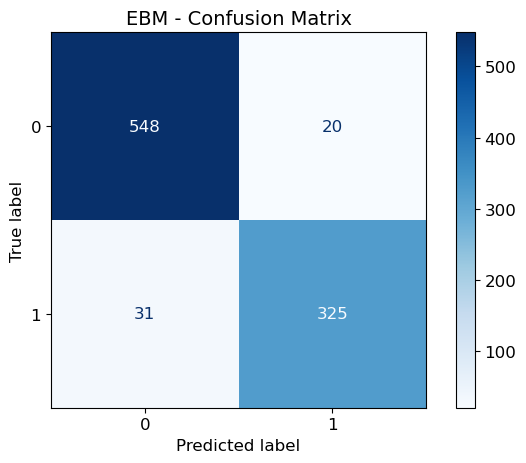

In [534]:

plt.rcParams.update({'font.size': 12})


disp = ConfusionMatrixDisplay.from_predictions(
    y_pred=y_pred_test, 
    y_true=y_test_int,
    cmap='Blues'
)
plt.title("EBM - Confusion Matrix", fontsize=14)
plt.tight_layout()
plt.savefig("/Users/ramon/Proyectos Data Science/Proyecto Lead Scoring/EBM_conf_matrix.png", dpi=300)
plt.show()

**The model performance is actually very good.**

F1-Score on Test Set:
- XGBoost: 0.9284
- EBM: 0.9272

### 7.1) Ploting Results:

#### Global Importance EBM:

In [435]:
data = ebm.explain_global().data()
print(data.keys())

dict_keys(['type', 'names', 'scores'])


In [496]:
feature_names = np.array(data['names'])
importances = np.array(data['scores'])



order = np.argsort(importances)[::-1] # This gives the indexes of the orden array by importances. By default is increasing. [::-1] turns it oposite, decreasing.

n_top = 10 

feature_names_sorted = feature_names[order][:n_top]
importances_sorted = importances[order][:n_top] # First n_top rows


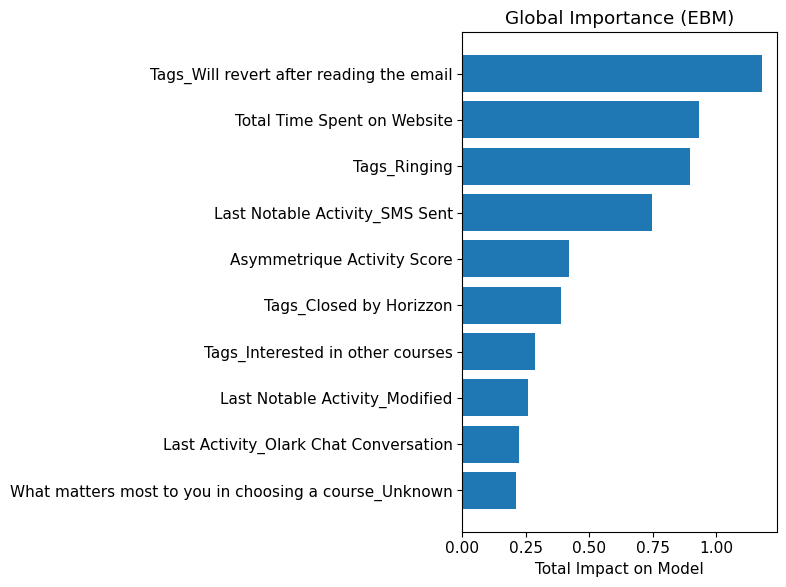

In [535]:
plt.rcParams.update({'font.size': 11})
plt.figure(figsize=(8, 6))
plt.barh(feature_names_sorted[::-1], importances_sorted[::-1])
plt.title("Global Importance (EBM)")
plt.xlabel("Total Impact on Model")
plt.tight_layout()
plt.savefig("/Users/ramon/Proyectos Data Science/Proyecto Lead Scoring/EBM_global_importance.png", dpi=300)
plt.show()

array(['Tags_Will revert after reading the email',
       'Total Time Spent on Website', 'Tags_Ringing',
       'Last Notable Activity_SMS Sent', 'Asymmetrique Activity Score',
       'Tags_Closed by Horizzon', 'Tags_Interested in other courses',
       'Last Notable Activity_Modified',
       'Last Activity_Olark Chat Conversation',
       'What matters most to you in choosing a course_Unknown'],
      dtype='<U96')

## EBM TopFeatures Prediction vs Conversion Rate:

### 1. Tags_Will revert after reading the email:

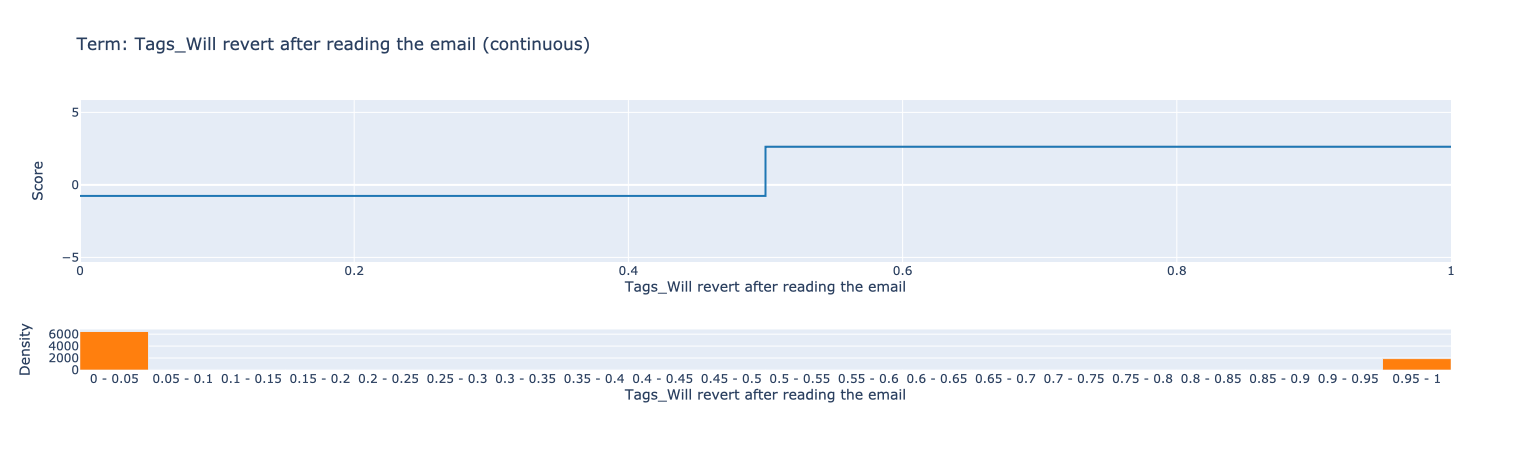

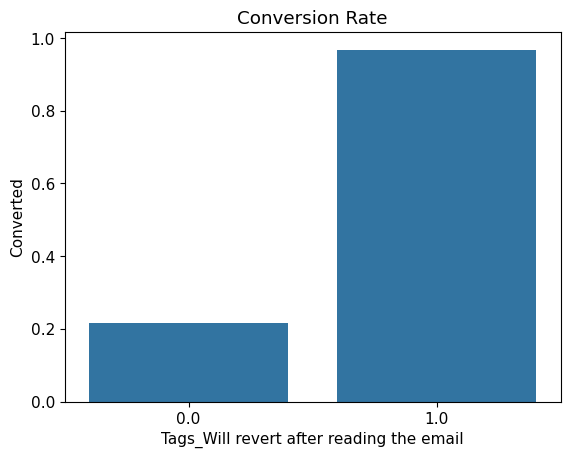

In [538]:
# Conversion Rate for Tags_Will revert after reading the email:

df_email = df_dum.loc[:,['Converted', 'Tags_Will revert after reading the email']]
df_email = df_email.groupby('Tags_Will revert after reading the email').mean().reset_index()
sns.barplot(df_email, x='Tags_Will revert after reading the email', y='Converted')
plt.title("Conversion Rate")
plt.savefig("/Users/ramon/Proyectos Data Science/Proyecto Lead Scoring/email_conv_rate.png", dpi=300)
plt.show()

TOP: The model predicts a higher probability of conversion if 'Tags_Will revert after reading the email' = 1.

BOTTOM: If we analyze the data we can see that those leads with 'Tags_Will revert after reading the email' = 1 actually convert more. This shows that the model prediciton for the individual feature actually correlates with data as opposed to SHAP Analysis.

### 2. Total Time Spent on Website:

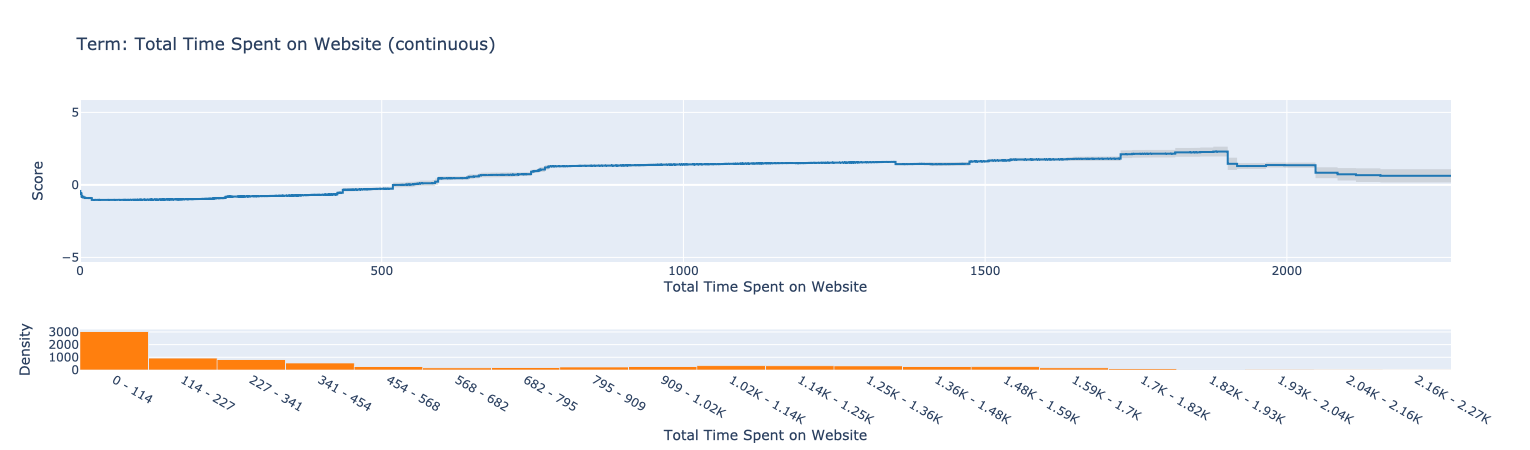

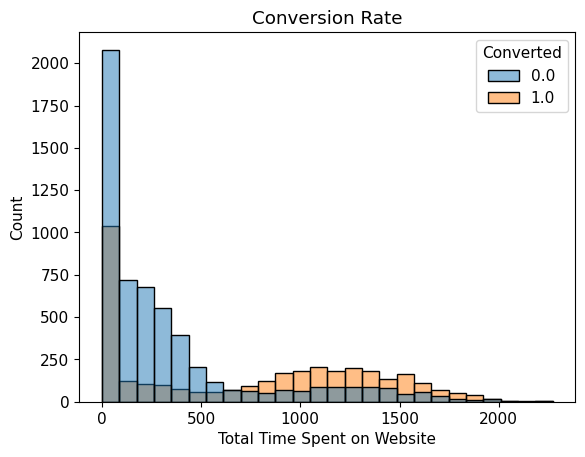

In [552]:
# Conversion Rate for Tags_Will revert after reading the email:

df_time_spent = df_dum.loc[:,['Converted', 'Total Time Spent on Website']].sort_values(by='Total Time Spent on Website',ascending=True)

sns.histplot(data=df_time_spent, x='Total Time Spent on Website', hue='Converted')
plt.title("Conversion Rate")
plt.savefig("/Users/ramon/Proyectos Data Science/Proyecto Lead Scoring/time_spent_conv_rate.png", dpi=300)
plt.show()

TOP: The model predicts that the probability of conversion is highest when Total Time Spent on Website is between 500-1800 s. 

BOTTOM: If we analyze the distribution of Converted Leads (orange) with respect of Total Time on Website we can see a high density o converted leads between 500-1800s. This shows that the model prediciton for the individual feature actually correlates with data as opposed to SHAP Analysis.

### 3. Last Notable Activity_SMS Sent:

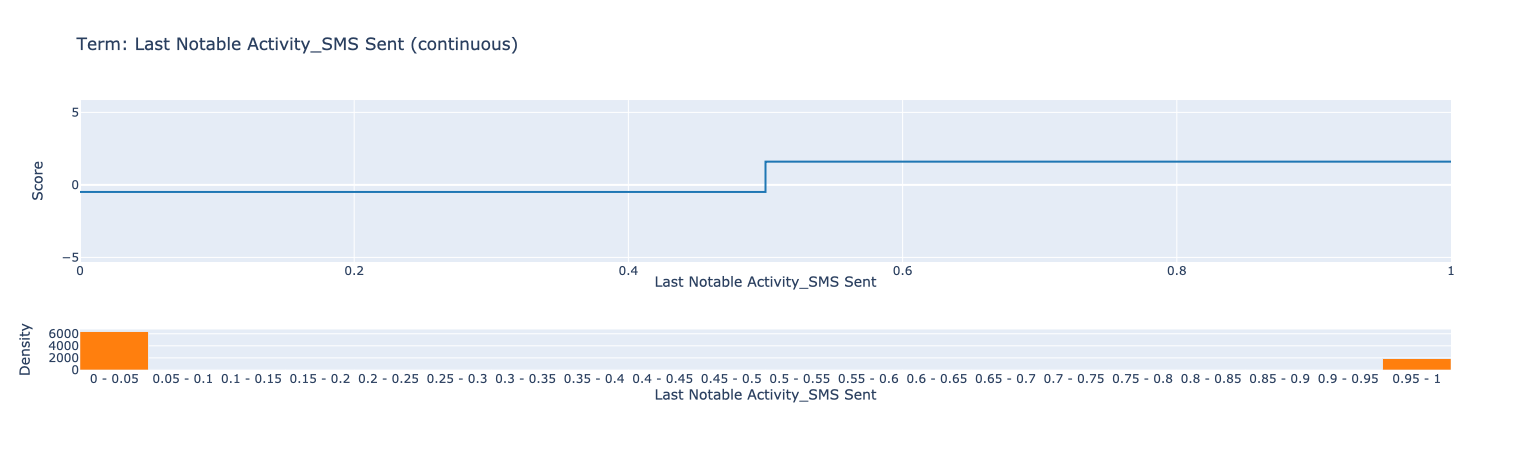

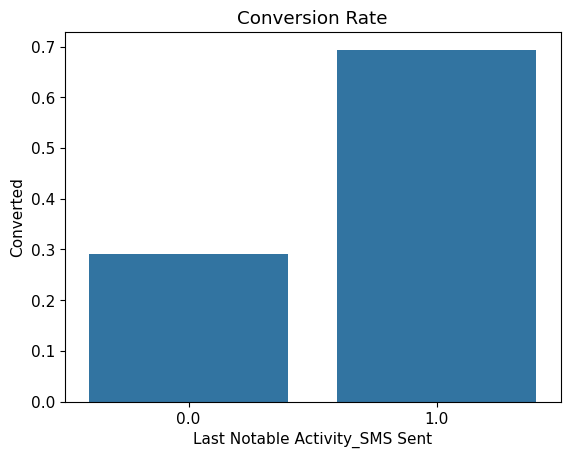

In [556]:
# Conversion Rate for Tags_Will revert after reading the email:

df_sms = df_dum.loc[:,['Converted', 'Last Notable Activity_SMS Sent']]
df_sms = df_sms.groupby('Last Notable Activity_SMS Sent').mean().reset_index()
sns.barplot(df_sms, x='Last Notable Activity_SMS Sent', y='Converted')
plt.title("Conversion Rate")
plt.savefig("/Users/ramon/Proyectos Data Science/Proyecto Lead Scoring/sms_conv_rate.png", dpi=300)
plt.show()

TOP: The model predicts that the probability of conversion is highest when 'Last Notable Activity_SMS Sent' = 1. 

BOTTOM: If we analyze the data we can see that those leads with 'Last Notable Activity_SMS Sent' = 1 actually convert more. This shows that the model prediciton for the individual feature actually correlates with data.

# Final Results Analysis

After training both models—XGBoost with SHAP and the Explainable Boosting Machine (EBM), we compared their outputs to assess not only predictive performance but also how well their interpretations aligned with observable data patterns.

While SHAP provides a powerful interpretability framework for black-box models like XGBoost, some feature-level effects were ambiguous or difficult to reconcile with real-world outcomes. In contrast, EBM’s transparent structure allowed for direct interpretation of how each feature influenced the model's predictions, and whether those effects matched actual lead conversion patterns.

Here we focus on the most relevant features as identified by the EBM model:

---

### 1. Feature: `Tags_Will revert after reading the email`

- **Model Prediction**: The model predicts a **higher probability of conversion** when this tag is present (`= 1`).
- **Observed Data**: Leads with this tag indeed show a **higher actual conversion rate**.
- This indicates that EBM’s prediction is **well aligned with the true behavior of leads**, whereas SHAP analysis showed inconsistencies for this feature.

---

### 2. Feature: `Total Time Spent on Website`

- **Model Prediction**: The model predicts the **highest conversion probability** when the total time spent on the website is between **500 and 1800 seconds**.
- **Observed Data**: A **high density of converted leads** is observed in this time range, confirming that the model captured a meaningful behavioral signal.
- This indicates that **EBM effectively identified a conversion “sweet spot”** for user engagement time.

---

### 3. Feature: `Last Notable Activity_SMS Sent`

- **Model Prediction**: Leads with `'Last Notable Activity_SMS Sent' = 1` are predicted to have a **higher probability of conversion**.
- **Observed Data**: These leads do in fact **convert more frequently**, indicating a positive impact of SMS follow-up activity.
- This consistency strengthens the interpretation that **SMS contact plays a valuable role in lead conversion**.

---

## Recommended Actions for the Marketing Team

Based on these results, the following data-driven strategies are recommended:

1. **Prioritize SMS Outreach**: Since leads with a recent SMS interaction show higher conversion rates, integrating or intensifying SMS campaigns could be an effective conversion lever. Consider automated SMS follow-ups for warm leads.

2. **Segment Leads by Website Engagement Time**: Leads spending between **500 and 1800 seconds** on the website represent a high-conversion segment. Flagging and prioritizing these leads in the CRM can improve targeting efficiency.

3. **Design Content to Encourage Sustained Engagement**: Given that mid-range time-on-site correlates with conversion, marketing and UX teams can collaborate to structure landing pages and content to **retain users longer within the optimal time window**.

4. **Use Interpretable Models for Operational Insights**: EBM not only performs competitively but also provides actionable insights. Integrating interpretable models into marketing analytics pipelines can improve both decision-making and stakeholder communication.



